<a href="https://colab.research.google.com/github/snayak13/MAE-598-Projects/blob/Project-1/SB_MAE_598__Rocket_Landing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Gradient-based rocket landing problem using differentiable programming


## Problem statement

Examine the two-dimensional rocket landing by defining the state vector as $x(t)=[x_1(t), x_2(t), \dot{x}_1(t), \dot{x}_2(t),  \phi(t)]^T$, with $x_1$ and $x_2$ representing the x and y positional coordinates, $\dot{x}_1, \dot{x}_2 $ are rocket velocities along x and y directions and $\phi$ indicating the rocket's orientation. The discrete-time dynamics of this system are described as follows:

$$
\begin{aligned}
x_1(t+1) = x_1(t) + \dot{x}_1(t) \Delta t - 2\Delta t^2 u_1 sin(\phi)(t), \\
x_2(t+1) = x_2(t) + \dot{x}_2(t) \Delta t + 2\Delta t^2 (u_1 cos(\phi)(t)-g), \\ \\
\dot{x}_1(t+1) = \dot{x}_1(t) - 1.5 u_1(t) sin(\phi) \Delta t + u_2(t) \Delta t, \\
\dot{x}_2(t+1) = \dot{x}_2(t) + 1.5 u_1(t) cos(\phi) \Delta t, \\
\phi(t+1) = \phi(t) - u_3(t) \Delta t, \\
\end{aligned}
$$
In this model, $u_1$ represents the main thruster, $u_2$ the side thruster, and $u_3$ the orientation control. The side thrust is included to enhance the controllability of the x-direction velocity to improve controlled actuation in the rocket. $\Delta t$ denotes the time interval. The closed-loop controller is defined as:

$$
a(t) = f_{\theta}(x(t))
$$

Here, $f_{\theta}(\cdot)$ symbolizes a neural network with parameters $\theta$, determined through optimization.

For each timestep, a loss function relative to the control input and state is assigned: $l(x(t),a(t))$. In this instance, we set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the terminal timestep, and $l(x(T),a(T)) = ||x(T)||^2 = x_1(T)^2 + x_1(T)^2 + \phi(T)^2 + \dot{x}_1(T)^2  + \dot{x}_2(T)^2 $. This loss function aims to guide the rocket towards $x_1(T)= x_2(T) = \phi(T) =  0$ and $\dot{x}_1(T)= \dot{x}_2(T) = 0$, constituting proper landing conditions.

The optimization challenge is thus posed as:

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & x_1(t+1) = x_1(t) + \dot{x}_1(t) \Delta t - 2\Delta t^2 u_1 sin(\phi)(t), \\
\quad & x_2(t+1) = x_2(t) + \dot{x}_2(t) \Delta t + 2\Delta t^2 (u_1 cos(\phi)(t)-g), \\ \\
\quad & \dot{x}_1(t+1) = \dot{x}_1(t) - 1.5 u_1(t) sin(\phi) \Delta t + u_2(t) \Delta t, \\
\quad & \dot{x}_2(t+1) = \dot{x}_2(t) + 1.5 u_1(t) cos(\phi) \Delta t, \\
\quad & \phi(t+1) = \phi(t) - u_3(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem appears constrained, it can be reformulated as an unconstrained problem in terms of $\theta$, considering that each $x(T-1)$ depends on $x(T-2)$ and $a(T-2)$, and so forth.

Next, we will implement this problem using pytorch, which enables the construction of only the forward pass of the loss (i.e., the progression from $x(1)$ to $x(2)$ and subsequently to $x(T)$), and automatically computes the gradient $\nabla_{\theta} l(x(T),a(T))$.

In [1]:


import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval used
GRAVITY_ACCEL = 0.12  # gravity constant used for the problem
BOOST_ACCEL = 0.3  # thrust constant used for this problem



In [3]:
# This code defines a class Dynamics, which is a subclass of nn.Module from the PyTorch library.
# The purpose of this class is to model the dynamics of a system, a rocket in a 2D space,
# based on its current state and actions applied to it

class Dynamics(nn.Module):

    # This is the constructor for the Dynamics class. It initializes a new instance of the class.
    def __init__(self):
        super(Dynamics, self).__init__() # necessary for proper initialization in Python's class inheritance.

    @staticmethod     # it can be called without creating an instance of the Dynamics class.
    def forward(state, action): # The forward method defines how the state of the system changes in response to an action

        """
        action[0]: main thruster
        action[1]: side thruster
        action[2]: orientation
        state[0] = x1
        state[1] = x2
        state[2] = x1_dot
        state[3] = x2_dot
        state[4] = phi
        """

        # Apply gravity
        delta_state_gravity = FRAME_TIME*t.tensor([0., 0., 0. , -GRAVITY_ACCEL, 0.]) # tensor to represent the effect of gravity on the system
        #  We consider gravity only affects the vertical velocity component (x2_dot).
        N = len(state)
        state_tensor = t.zeros((N, 5))

        state_tensor[:, 0] = -2*FRAME_TIME**2*t.sin(state[:, 4])
        state_tensor[:, 1] = 2*FRAME_TIME**2*t.cos(state[:, 4])

        state_tensor[:, 2] = -1.5*FRAME_TIME*t.sin(state[:, 4])
        state_tensor[:, 3] = 1.5*FRAME_TIME*t.cos(state[:, 4]) # 4cos0 and 4sin0

        # compute the changes in the state due to the main thruster (u1), side thruster (u2), and orientation control (u3).
        delta_state_u1 = BOOST_ACCEL * t.mul(state_tensor, action[:, 0].reshape(-1, 1))
        delta_state_u2 = 2*0.05*BOOST_ACCEL*FRAME_TIME* t.mul(t.tensor([0., 0., 1., 0., 0.]), action[:, 2].reshape(-1, 1))
        delta_state_u3 = FRAME_TIME* t.mul(t.tensor([0., 0., 0., 0., -1.]), action[:, 1].reshape(-1, 1))

        # create final state tensor and update it
        # Updates the state by adding the contributions from the thrusters and gravity.
        state = state + delta_state_u1 + delta_state_u2+delta_state_u3+ delta_state_gravity



        step_mat = t.tensor([[1., 0., FRAME_TIME, 0., 0.],
                            [0., 1., 0., FRAME_TIME, 0.],
                            [0., 0., 1., 0., 0.],
                            [0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 1.]
                            ])


        state = t.matmul(step_mat, state.T)
        return state.T # Returns the updated state, transposed back to its original shape

In [4]:
# defines a class Controller, which is a subclass of nn.Module from the PyTorch library.
# The class is designed to model a controller that outputs actions for a given system state

# class Controller that inherits from nn.Module, a base class for all neural network modules in PyTorch.
class Controller(nn.Module):
    # It initializes a new instance of the class with three parameters: dim_input (number of system states),
    # dim_hidden (size of the hidden layer, which is a design choice), and
    # dim_output (number of actions to be output by the controller).
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: choosen based on better performace
        """
        super(Controller, self).__init__()

        # Defines the neural network architecture of the controller
        self.network = nn.Sequential(
        nn.Linear(dim_input, dim_hidden),
        nn.Tanh(),
        nn.Linear(dim_hidden, dim_output),

        nn.Sigmoid())

    # The forward method defines how the input state is processed by the network.
    # In PyTorch, the forward method typically computes the output of a module.
    def forward(self, state):
        action = self.network(state)
        return action

In [5]:
# Simulation class, a subclass of nn.Module in PyTorch, is designed to simulate a dynamic system controlled by a neural network.
class Simulation(nn.Module):

    # initializes the simulation with a controller, dynamics model, and parameters
    # for the simulation (T for the number of time steps, N for the number of states).
    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.N = N
        self.action_trajectory = []
        self.state_trajectory = []

    # forward method defines the simulation process, taking an initial state as input.
    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []

        # In each step, it computes the action using the controller and updates the state using the dynamics model.
        # It then records the action and the new state.

        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)  # returns the error based on the final state.

    @staticmethod
    def initialize_state():
        state = t.rand((N, 5))
        state[:, 2] = 0  # vx = 0
        state[:, 3] = 0  # vy = 0

        return t.tensor(state, requires_grad=False).float()


    # computes the mean squared error of the state, which is used as a loss function to evaluate the performance of the controller.
    def error(self, state):
        return t.mean(state**2)

In [6]:
#  Optimize class was designed for optimizing a simulation using gradient descent methods in PyTorch.

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters() # Retrieves the parameters of the controller within the simulation, which will be optimized
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # Sets up the optimizer, using LBFGS (a quasi-Newton method)
        self.loss_list = [] # initializes a list to store the loss values during training.

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state) # Computes the loss for the current state of the simulation
            self.optimizer.zero_grad()  #   Clears old gradients, which is standard practice before computing new gradients
            loss.backward() #  Computes the gradient of the loss with respect to the parameters.
            return loss
        self.optimizer.step(closure) #  Performs a single optimization step.
        return closure()  # Returns the loss after the optimization step


    # Method for training the model over a specified number of epochs
    def train(self, epochs):
        for epoch in range(epochs):   # Iterates over each epoch
            loss = self.step()   # Performs an optimization step and retrieves the loss.
            self.loss_list.append(loss)  # Appends the loss to the loss list
            print('[%d] loss: %.3f' % (epoch + 1, loss))  #  Prints the epoch number and the corresponding loss.
            self.visualize()  # Calls the visualize method to display the results.



    # Method to visualize the trajectory of the system's states.
    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        x_history = []
        for i in range(self.simulation.N):
            x1 = data[i, :, 0]
            x2 = data[i,:, 1]
            x1_dot = data[i,:,2]
            x2_dot = data[i,:,3]
            phi = data[i,:,4]

            # Creating the subplot
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the figsize for better appearance

            # First plot
            axs[0].plot(x1, x2)
            axs[0].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
            axs[0].set_xlabel('X coordinate(m)')
            axs[0].set_ylabel('Y coordinate(m)')
            axs[0].set_title('X vs Y Position')

            # Second plot
            axs[1].plot(phi)
            axs[1].set_xlabel('Time')
            axs[1].set_ylabel('Orientation')
            axs[1].set_title('Orientation Over Time')

            # Third plot
            axs[2].plot(x1, x1_dot)
            axs[2].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
            axs[2].set_xlabel('X Position(m)')
            axs[2].set_ylabel('X Velocity(m/s)')
            axs[2].set_title('X Position vs Velocity')

            # Fourth plot
            axs[3].plot(x2, x2_dot)
            axs[3].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
            axs[3].set_xlabel('Y Position(m)')
            axs[3].set_ylabel('Y Velocity(m/s)')
            axs[3].set_title('Y Position vs Velocity')

            # Adjust layout for a cleaner look
            plt.tight_layout()




            plt.subplots_adjust(wspace=0.3)


            x_history.append(x1)
            x_history.append(x2)
            x_history.append(phi)

        plt.show()
        print('\n')
        np.save('rocket_states', x_history)


<ipython-input-5-22005dacaaee>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t.tensor(state, requires_grad=False).float()


[1] loss: 4.131


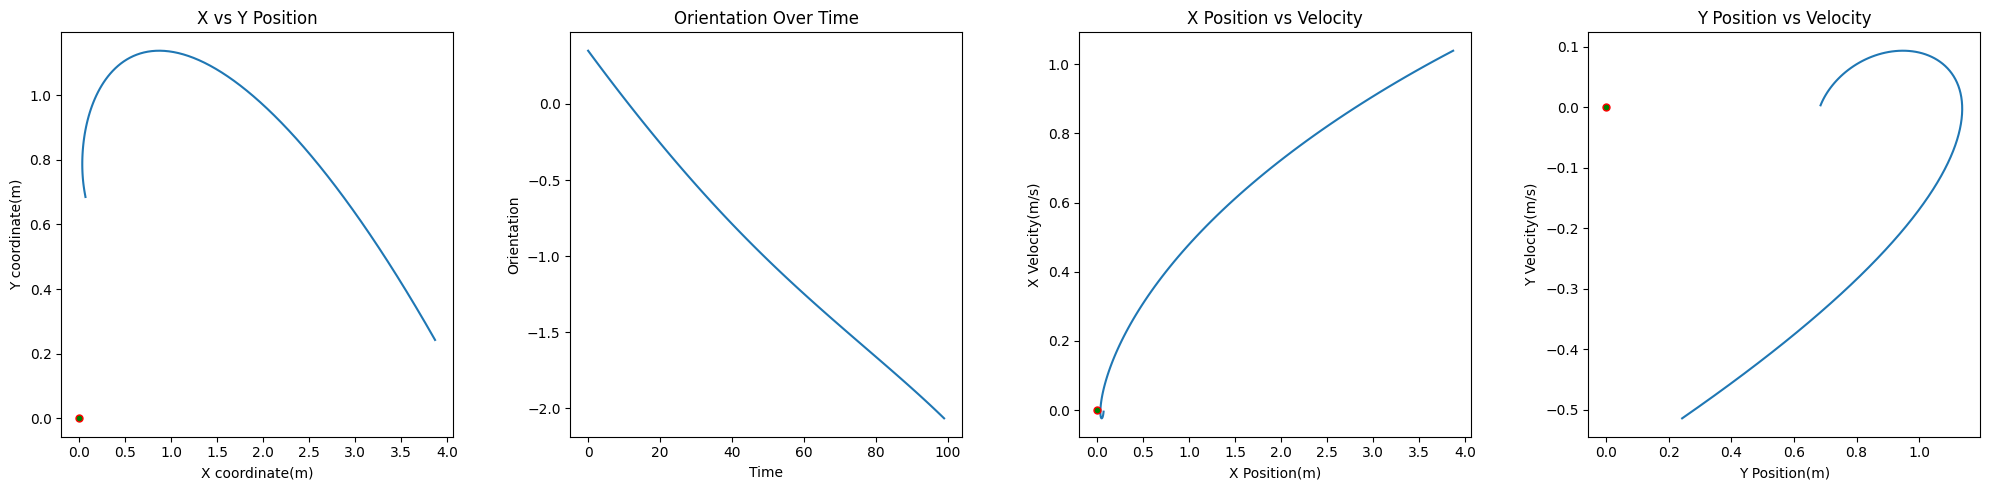



[2] loss: 1.908


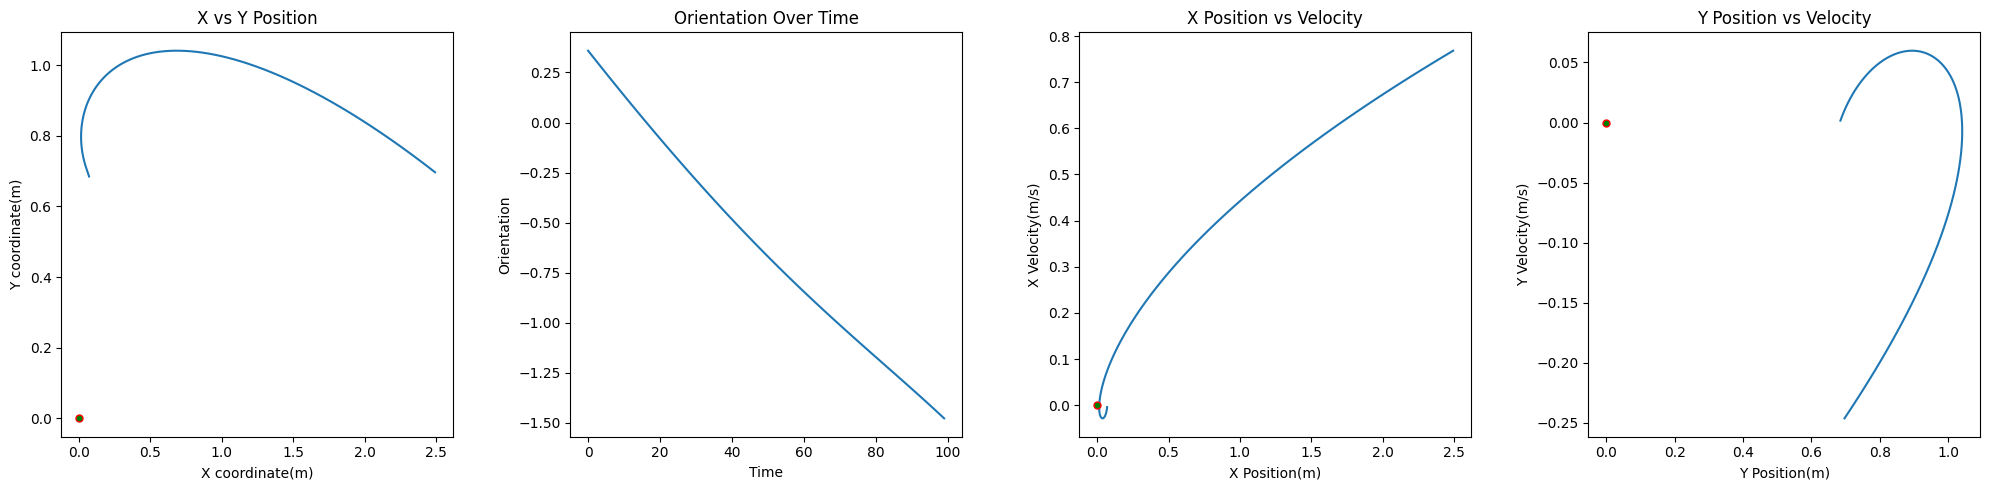



[3] loss: 0.953


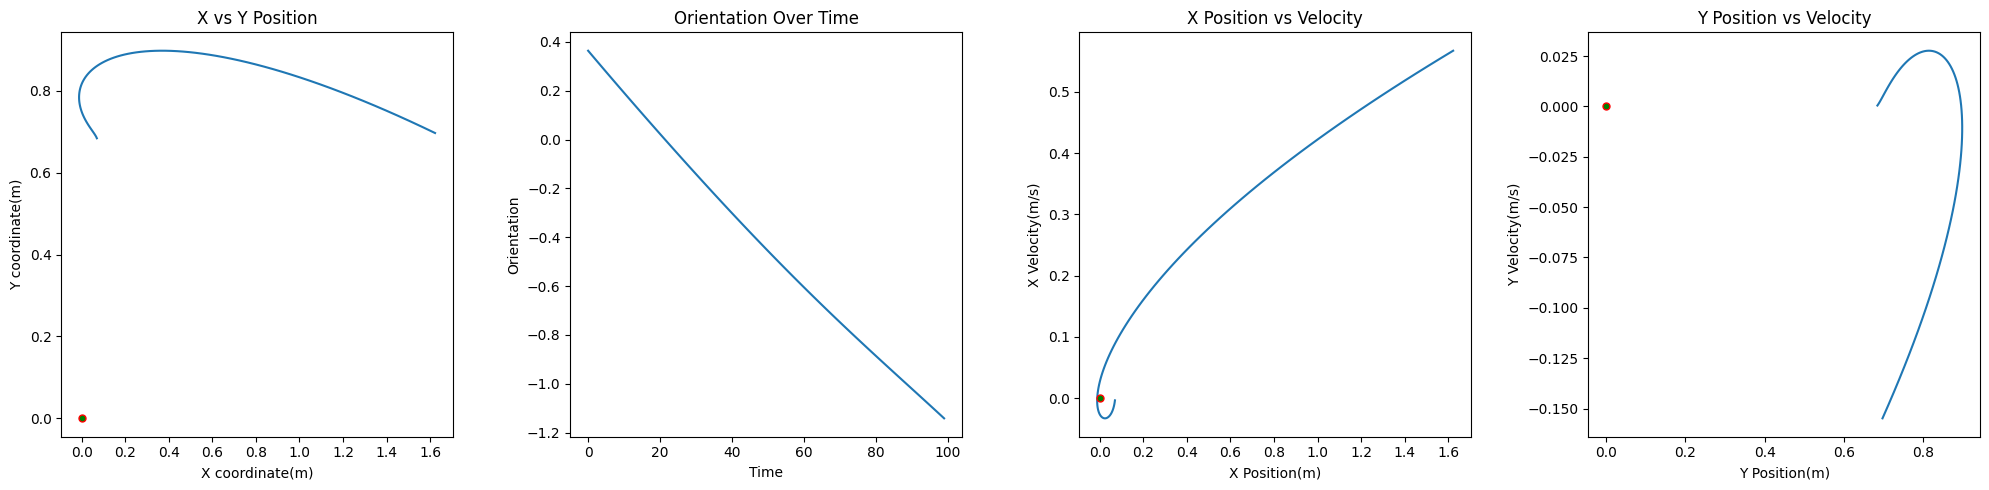



[4] loss: 0.539


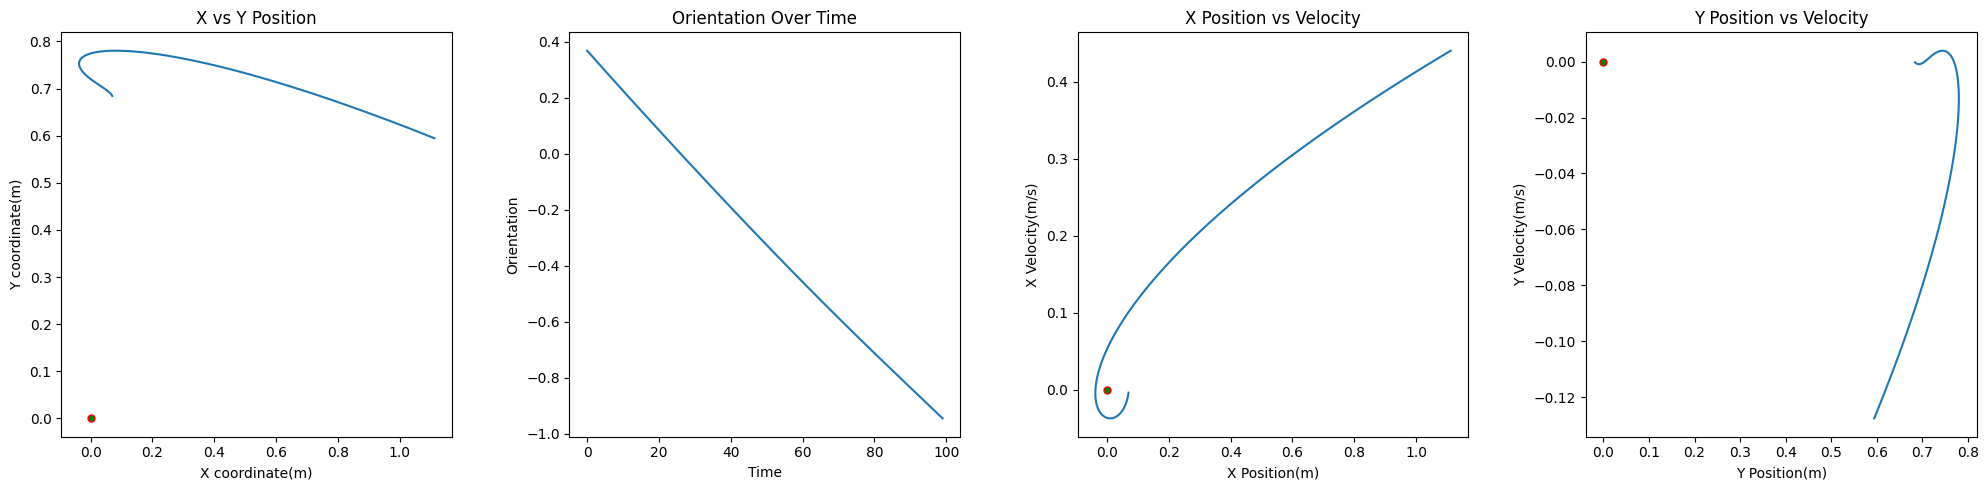



[5] loss: 0.339


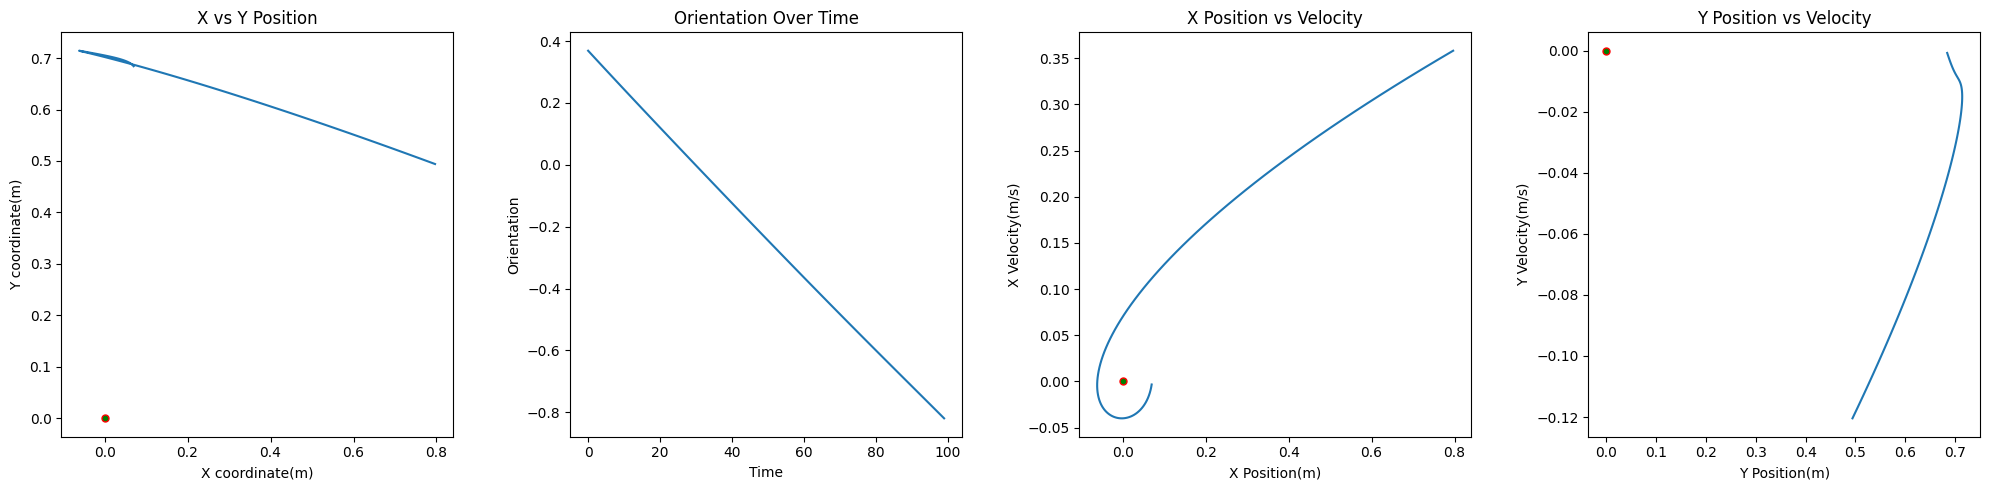



[6] loss: 0.224


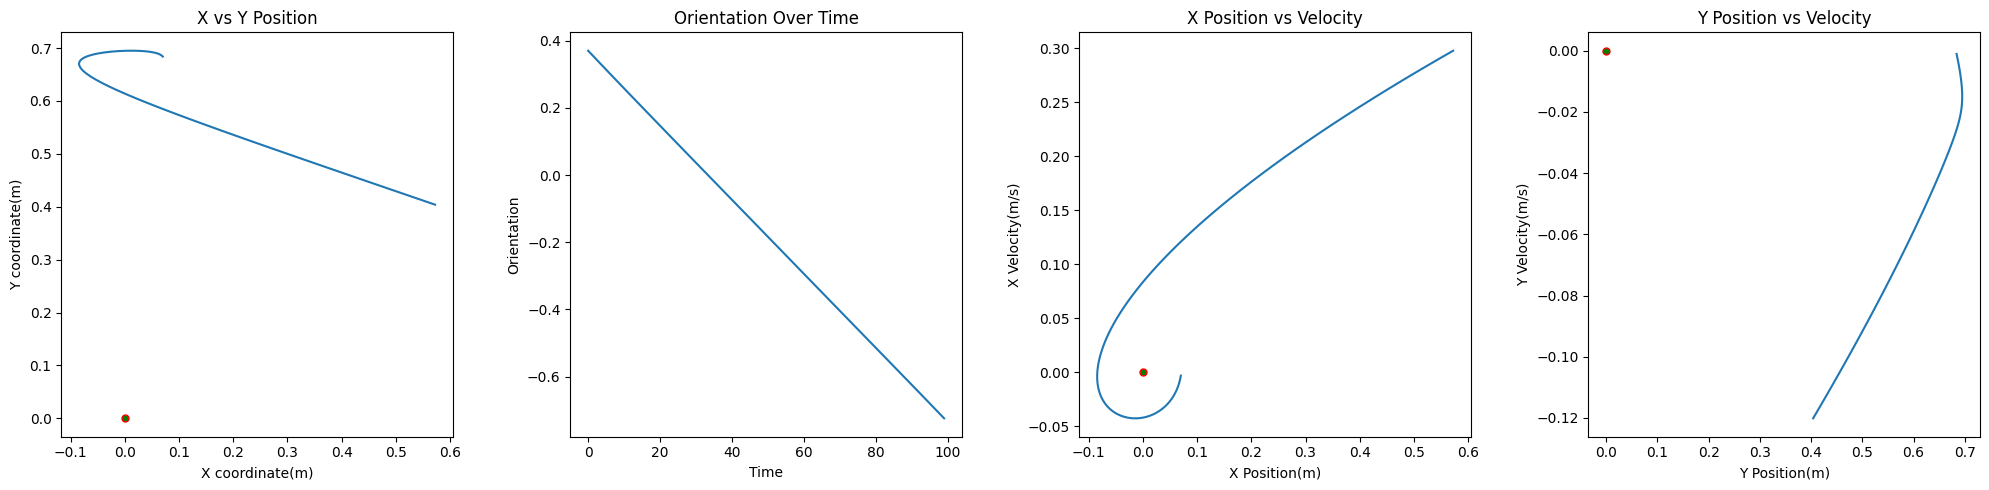



[7] loss: 0.150


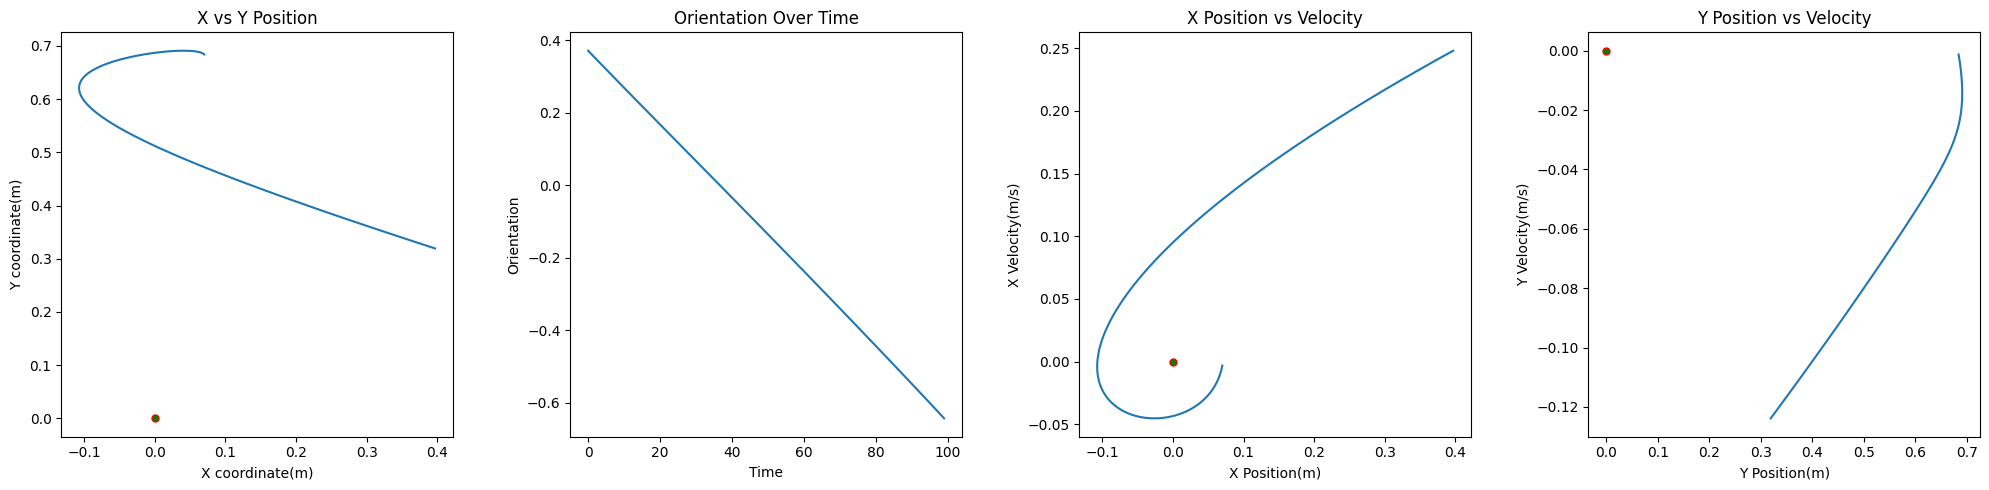



[8] loss: 0.097


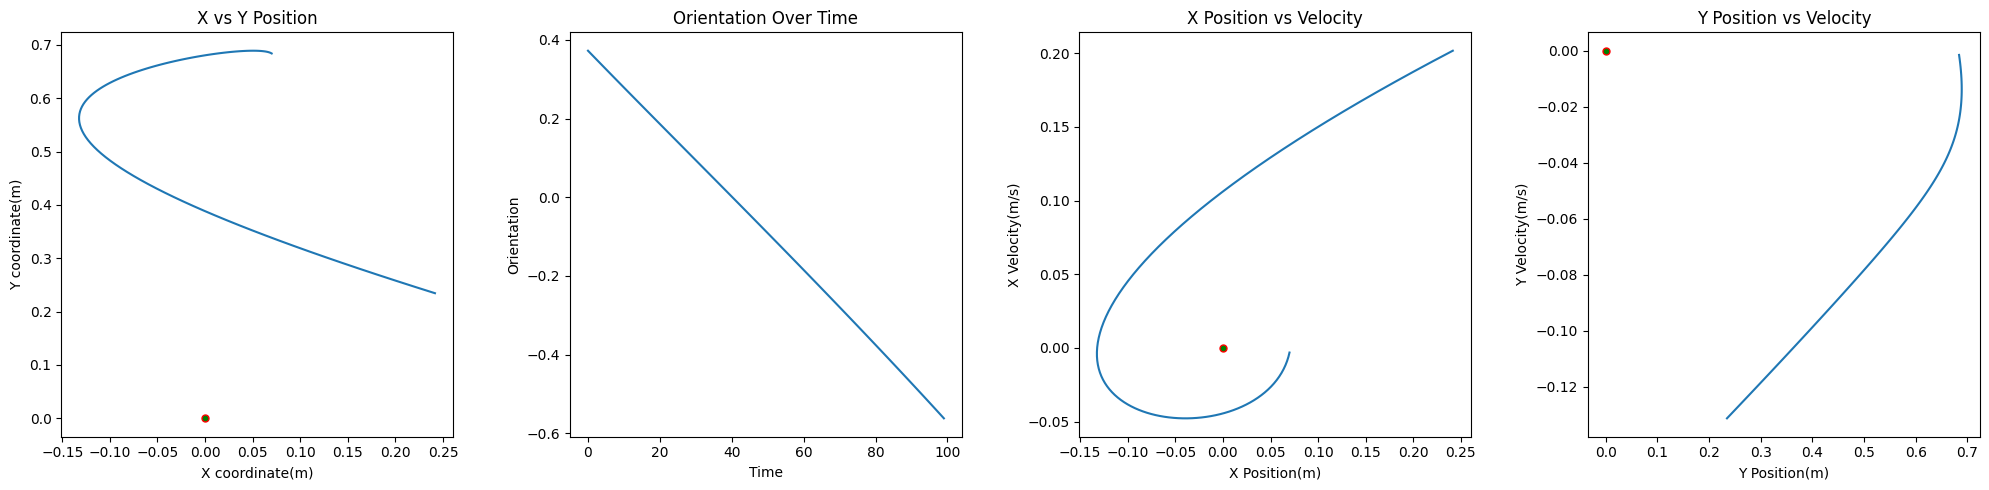



[9] loss: 0.068


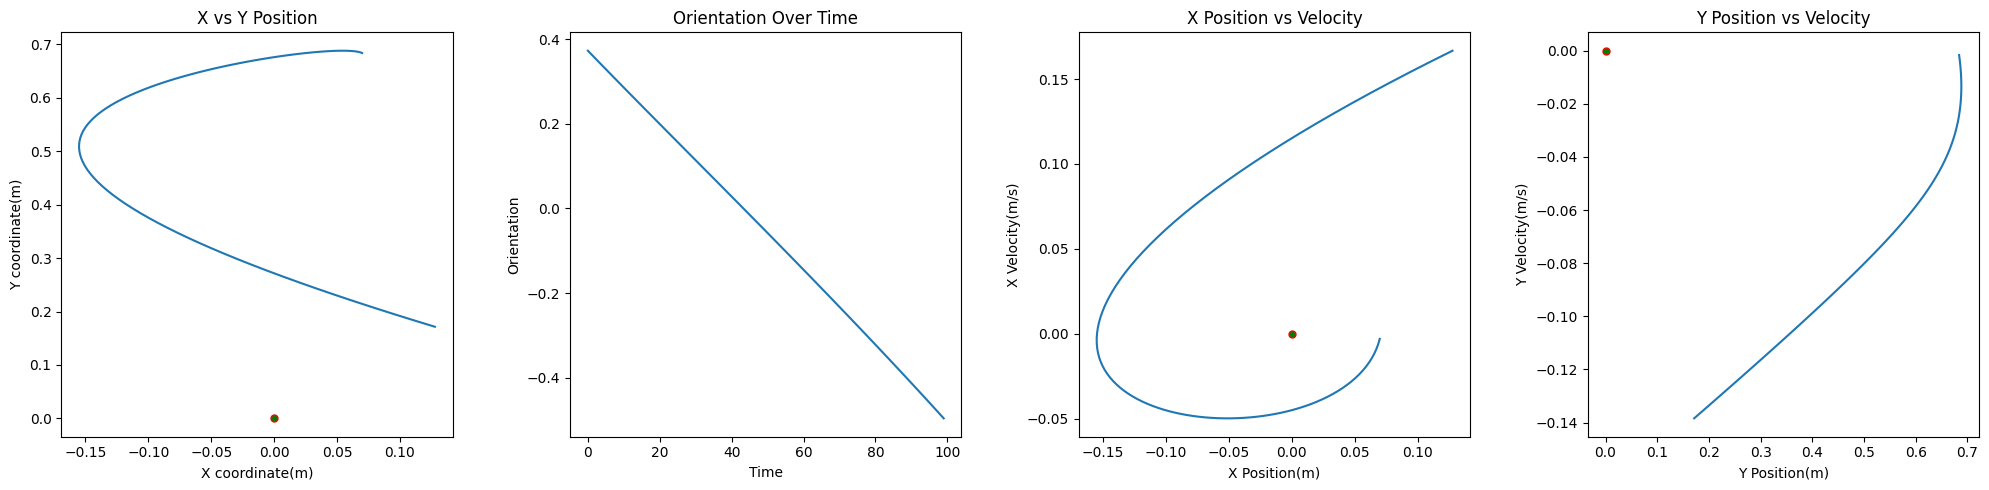



[10] loss: 0.052


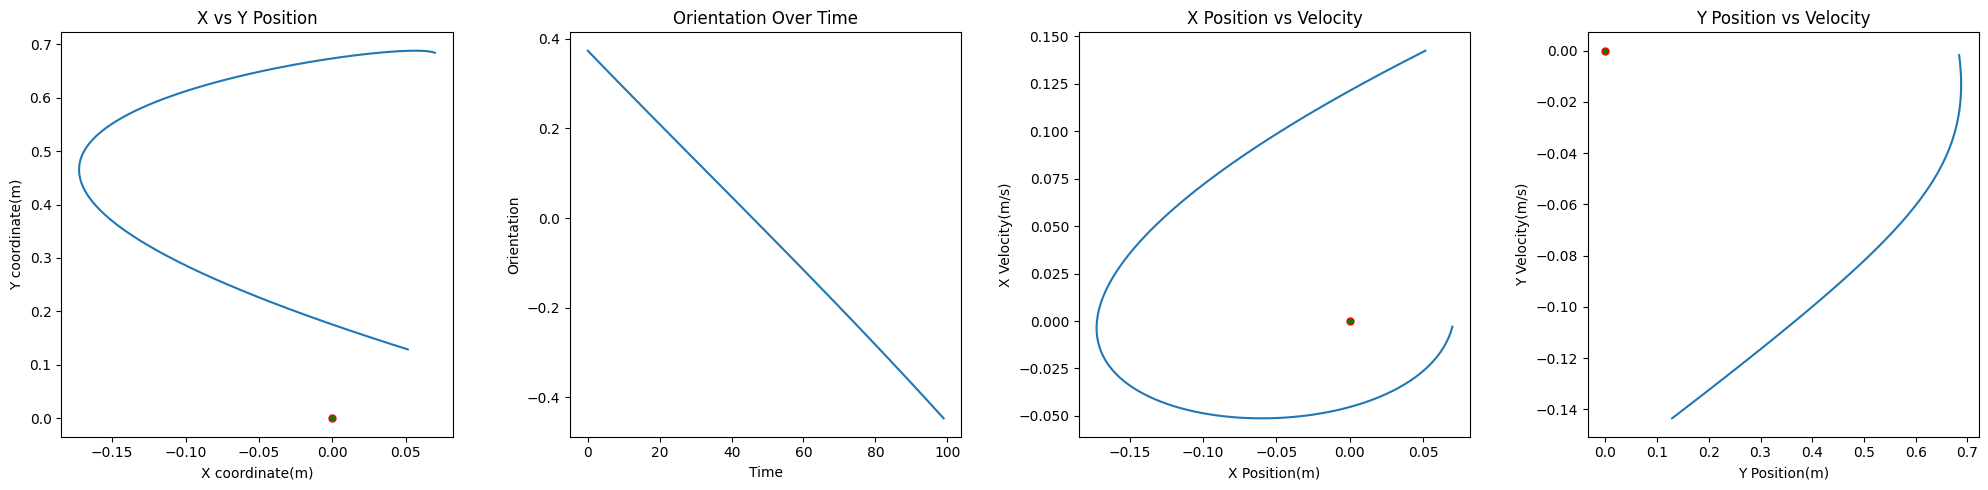



[11] loss: 0.042


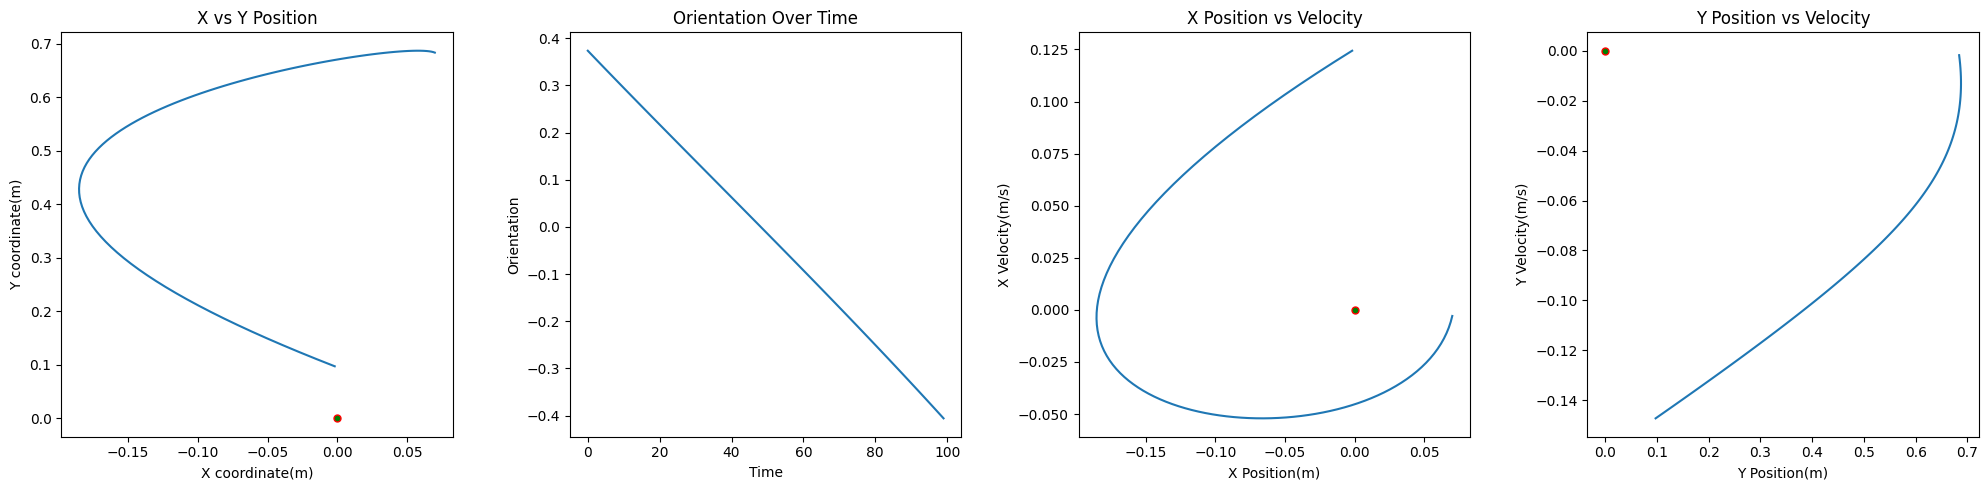



[12] loss: 0.035


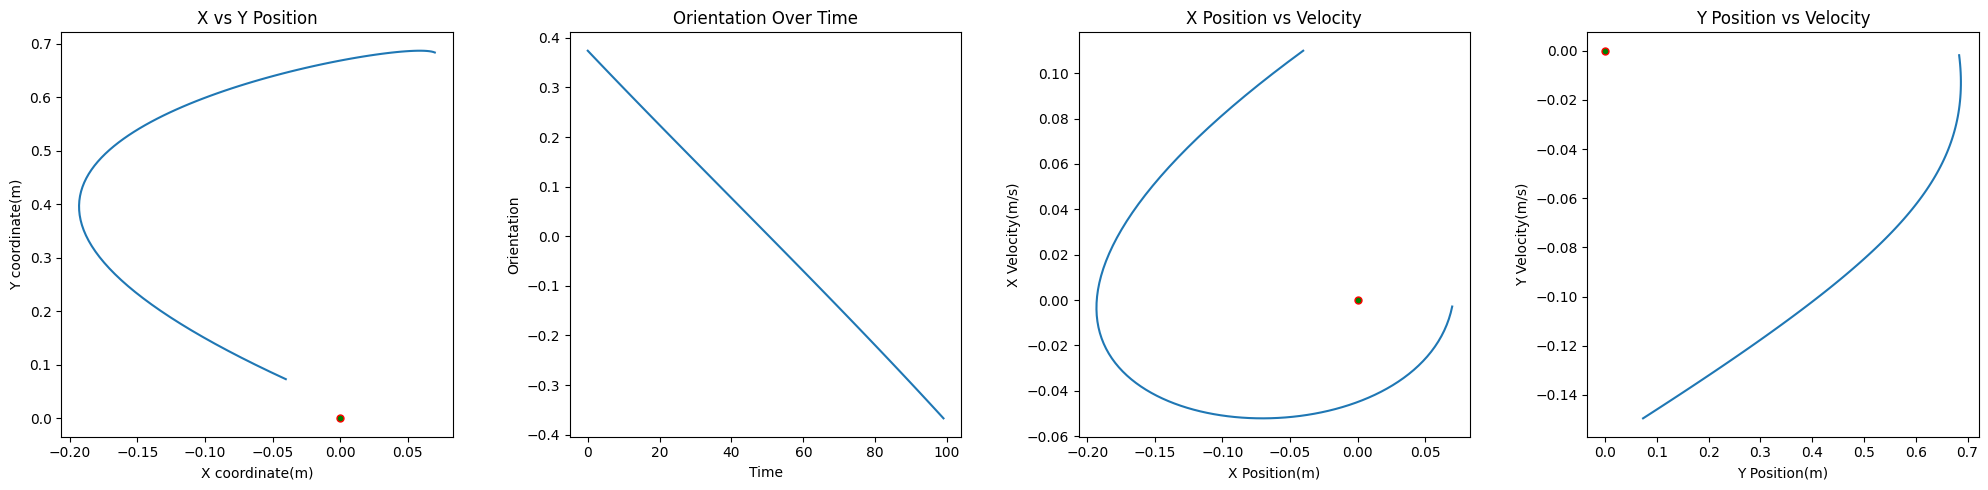



[13] loss: 0.029


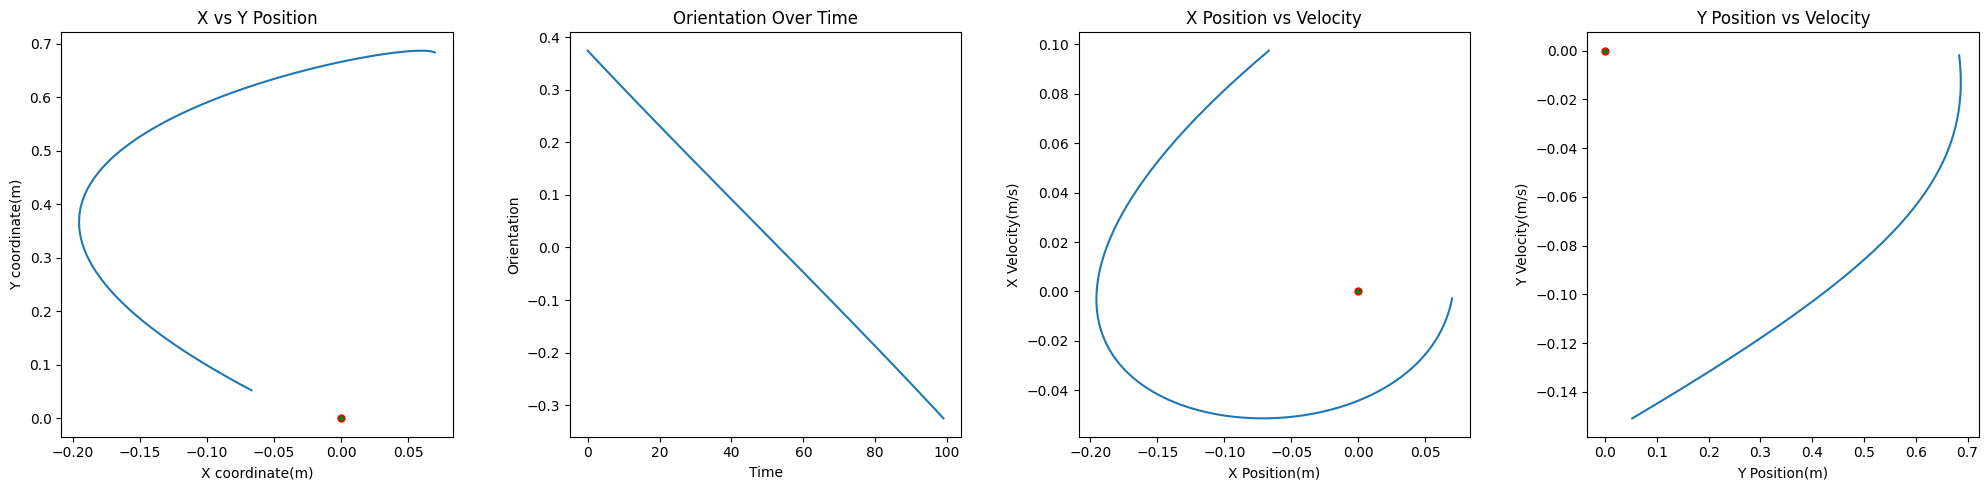



[14] loss: 0.023


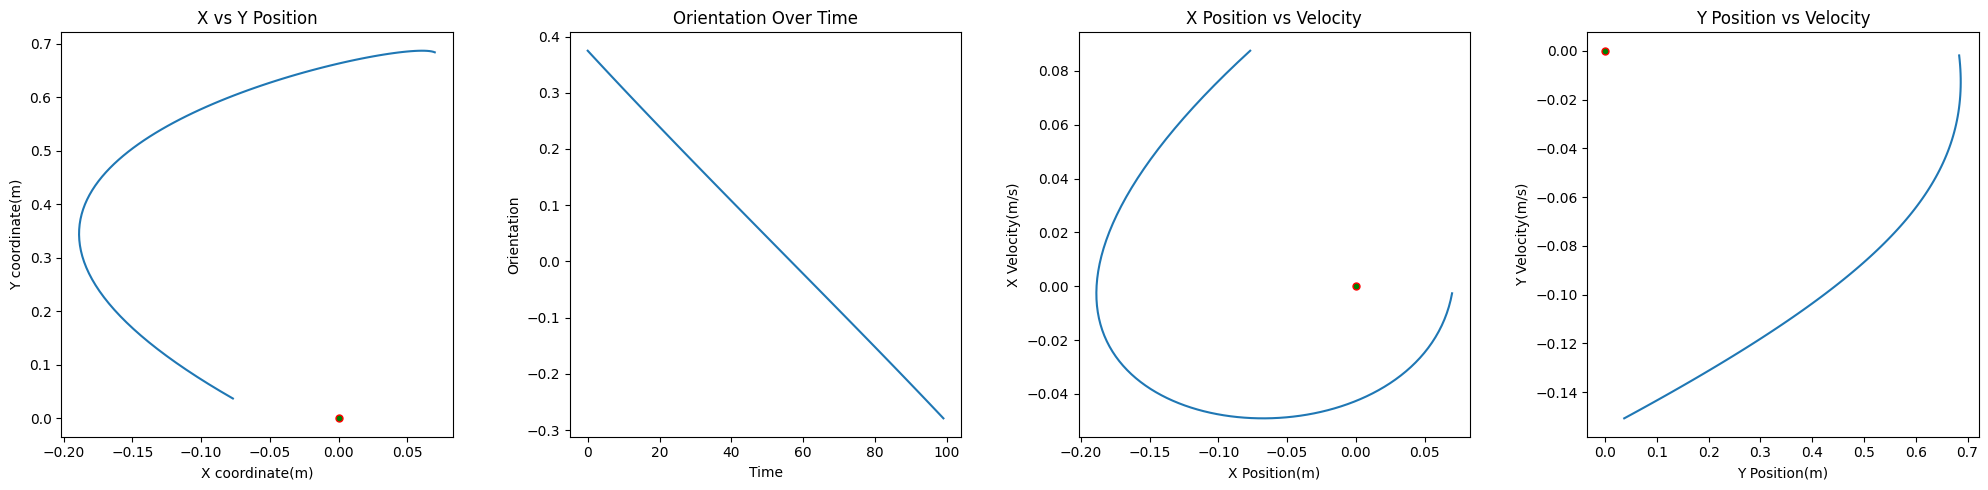



[15] loss: 0.017


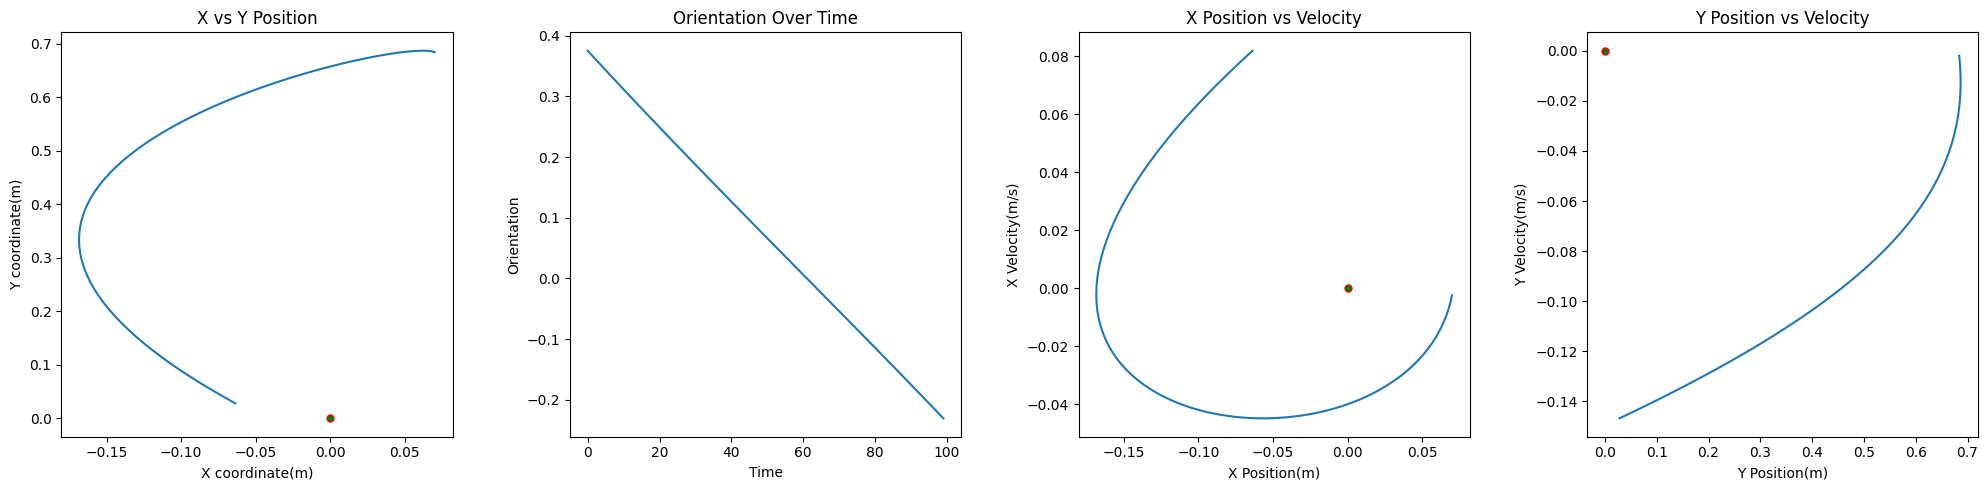



[16] loss: 0.011


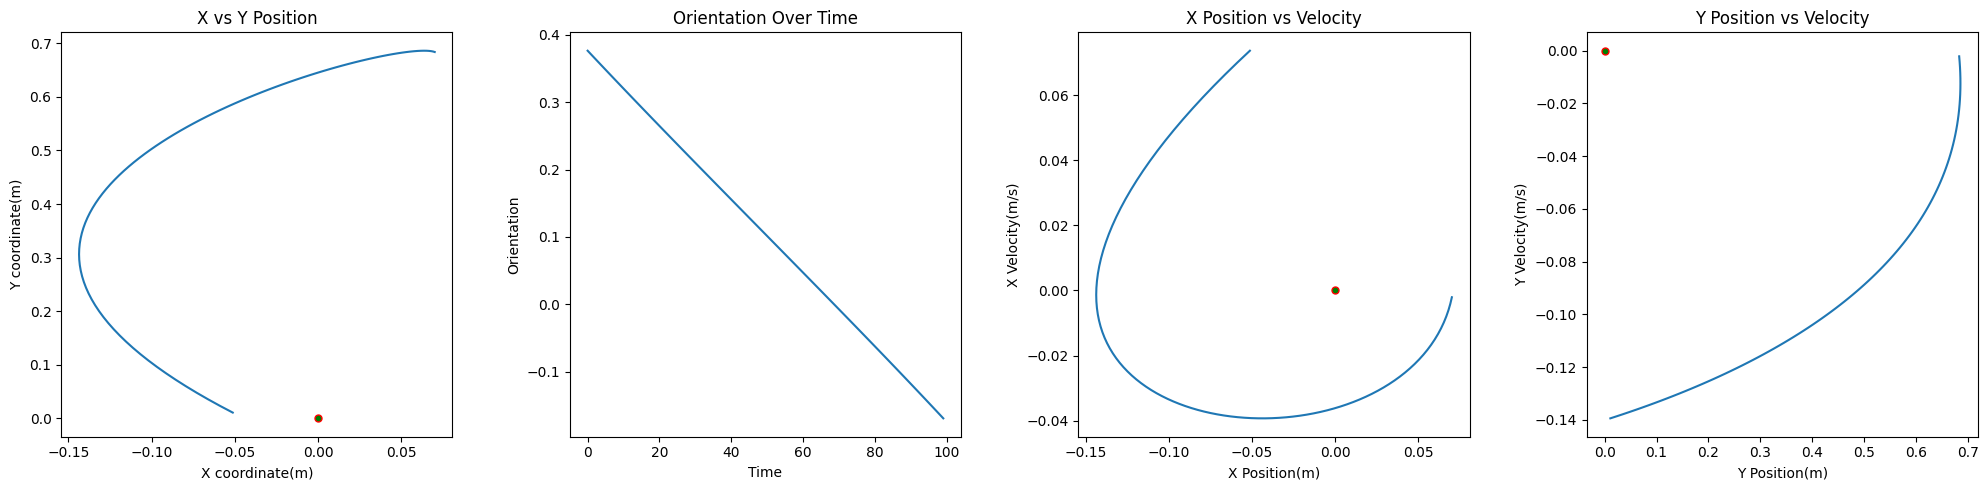



[17] loss: 0.009


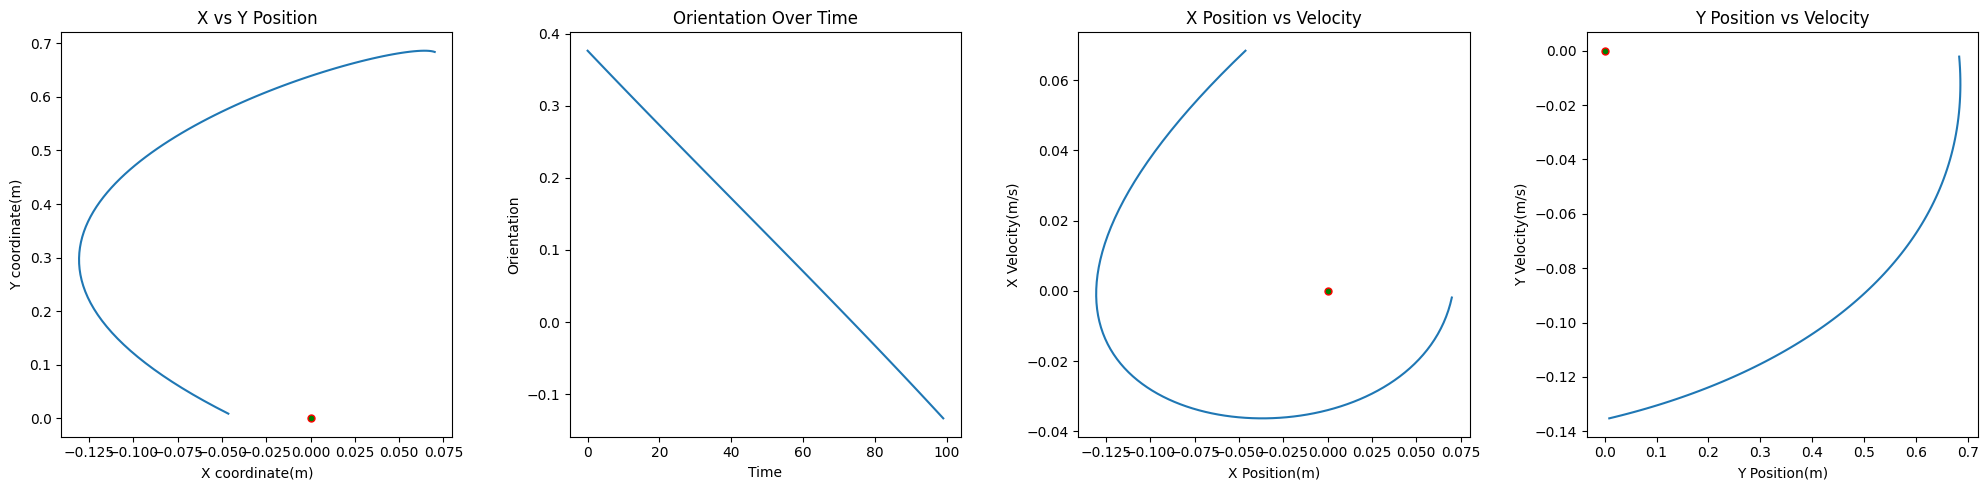



[18] loss: 0.007


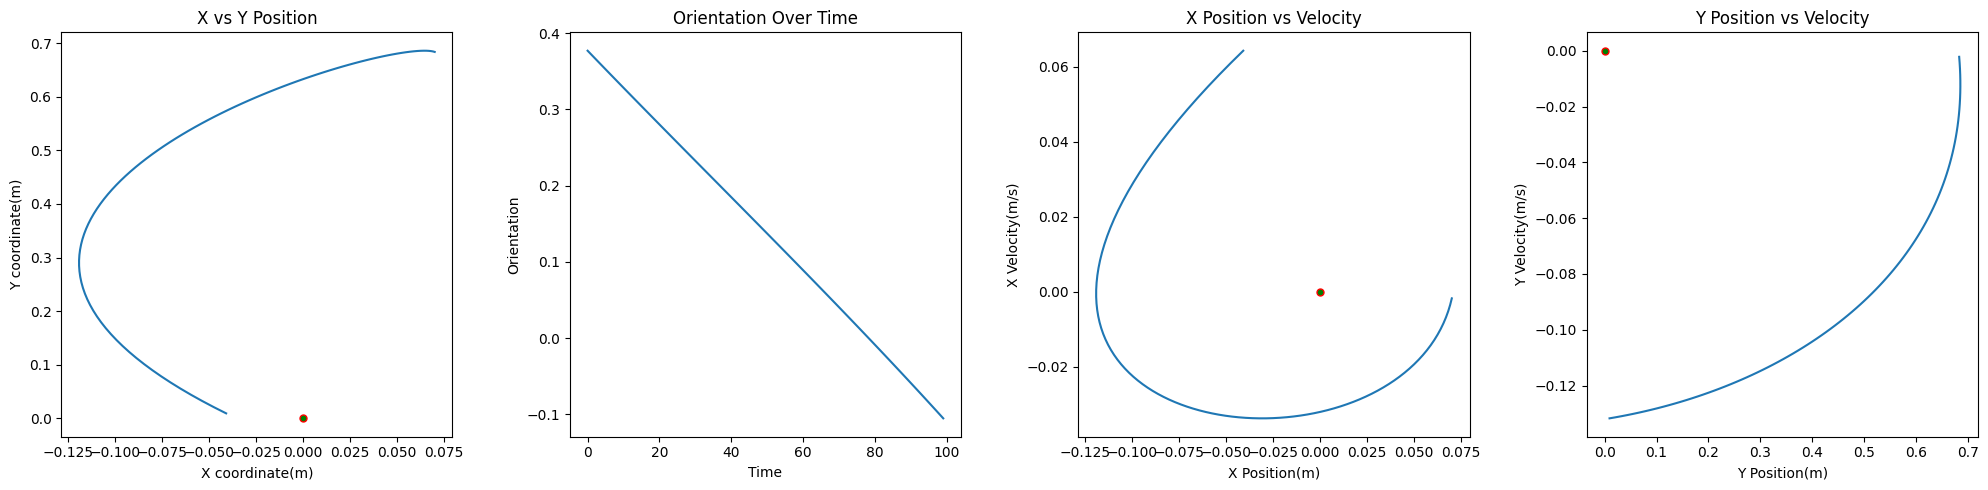



[19] loss: 0.006


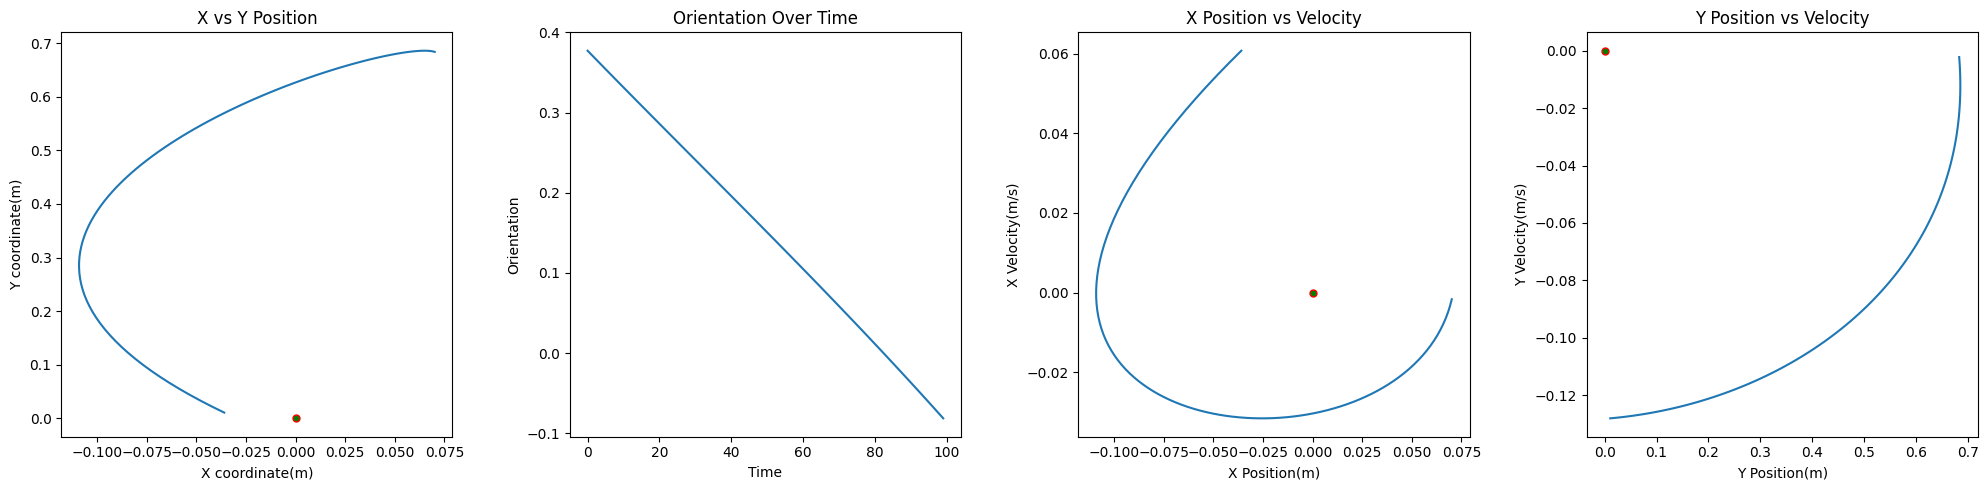



[20] loss: 0.004


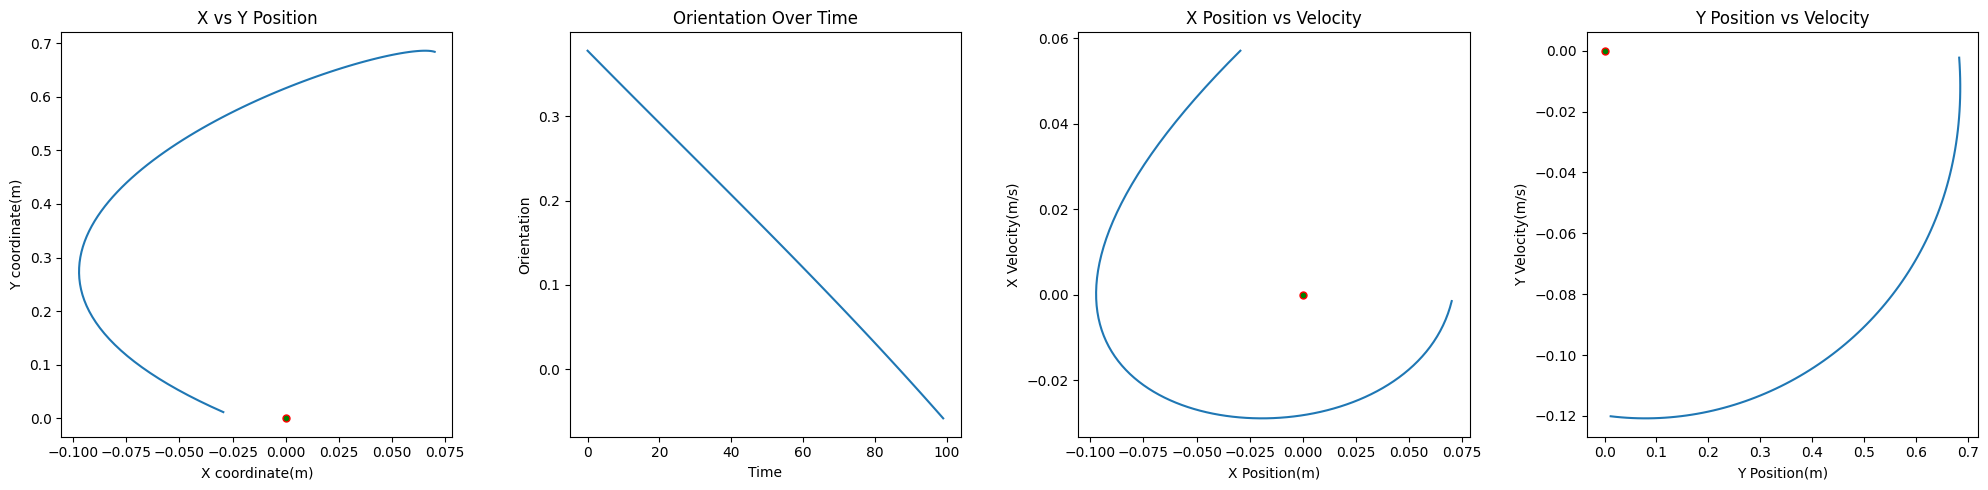



[21] loss: 0.002


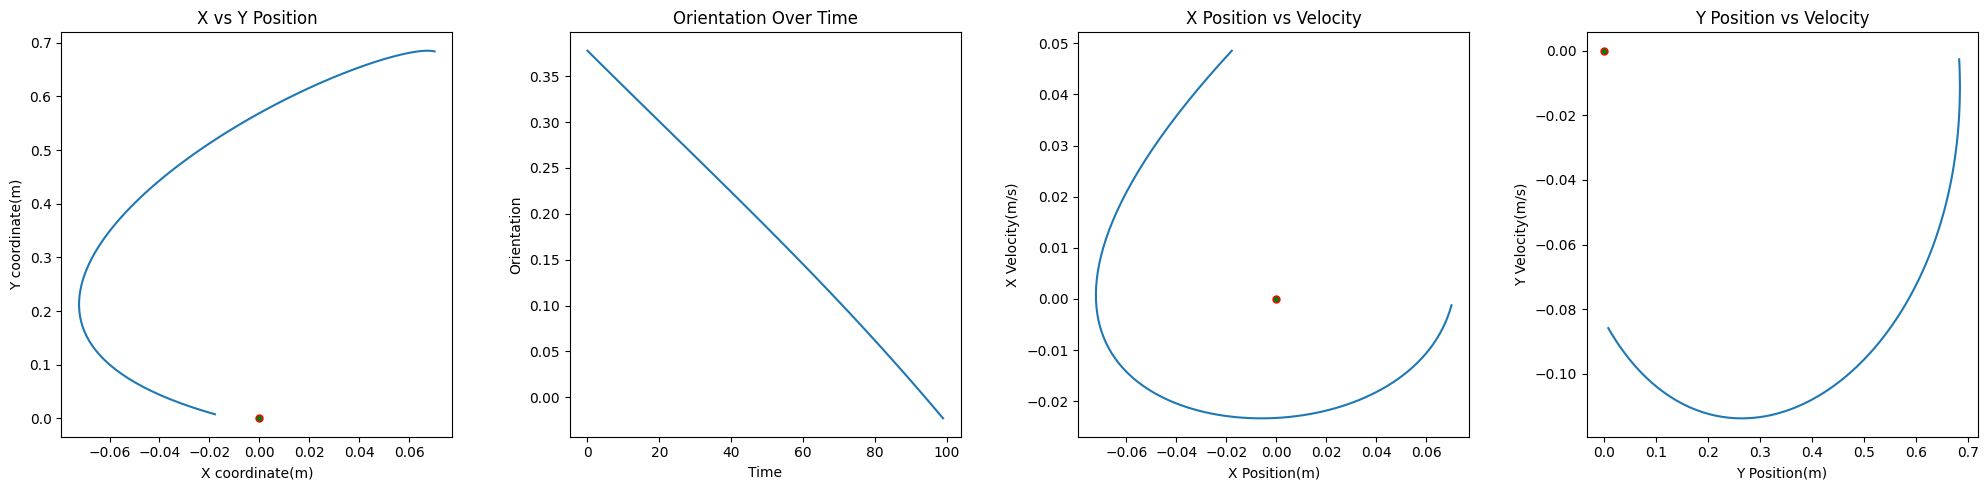



[22] loss: 0.001


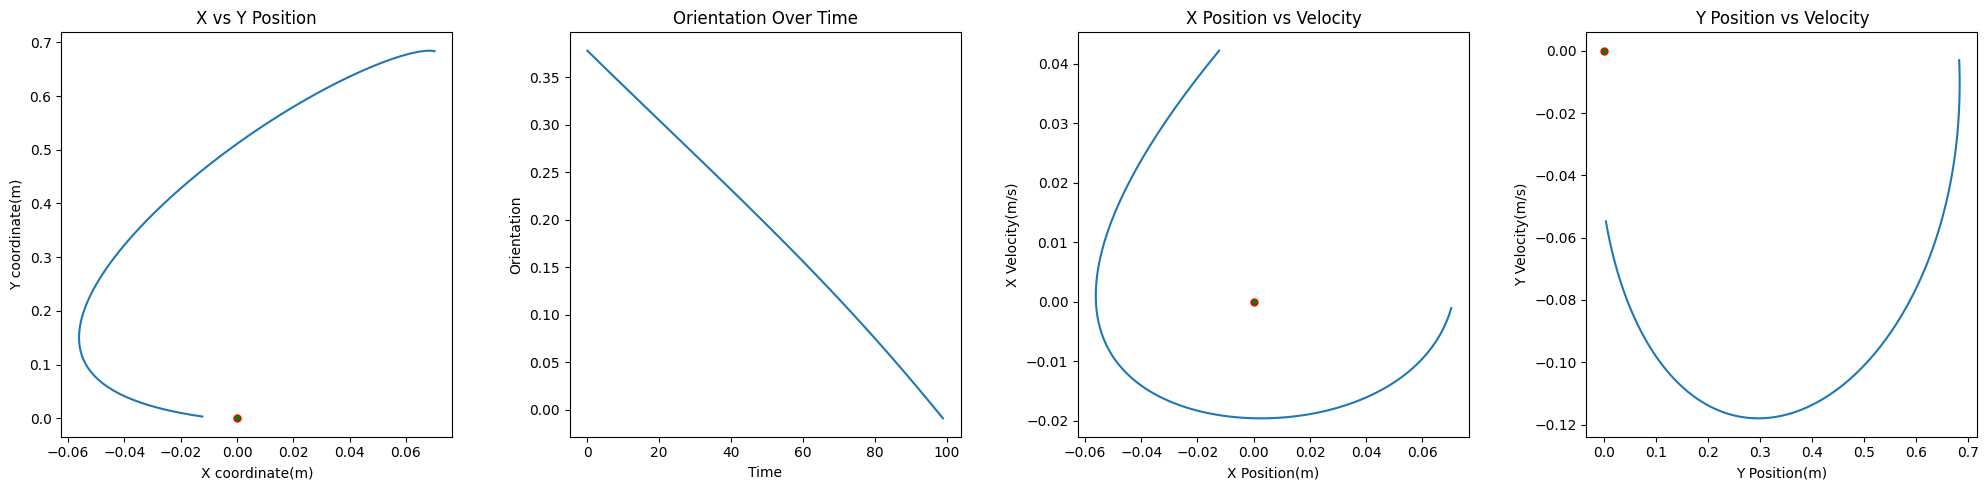



[23] loss: 0.001


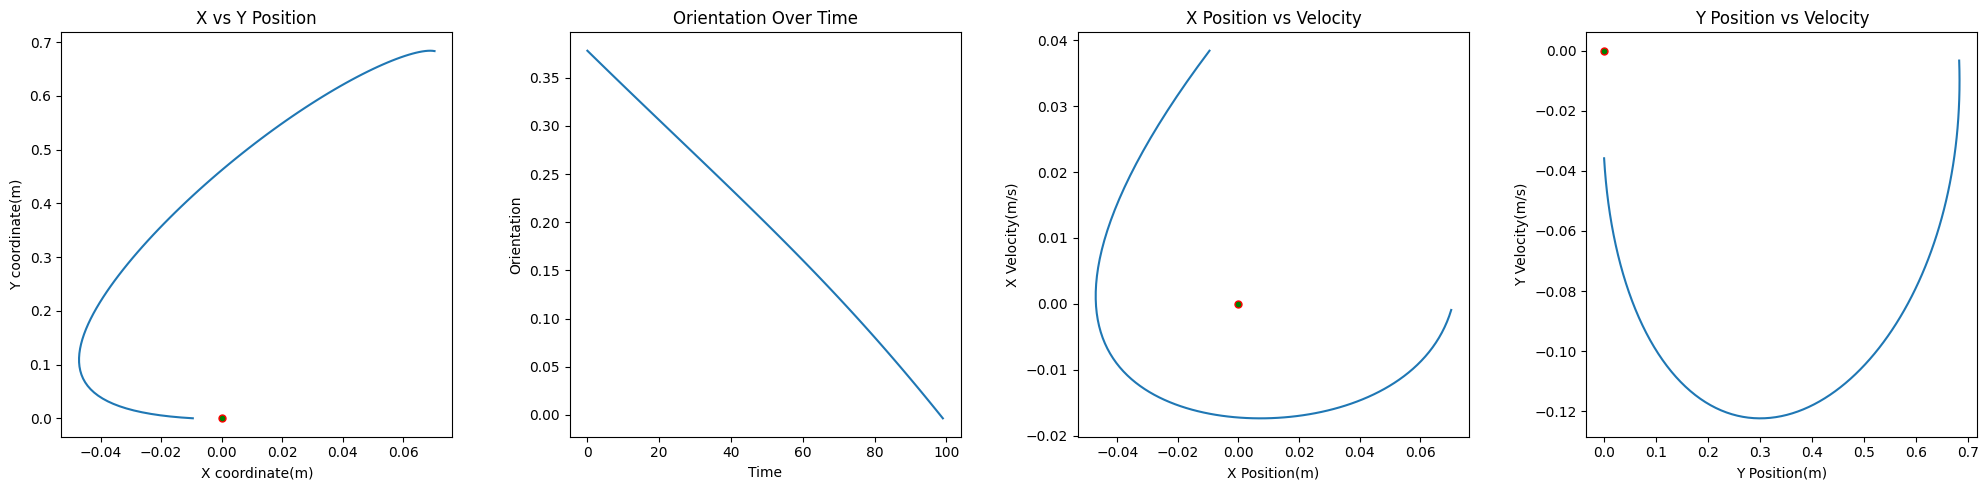



[24] loss: 0.000


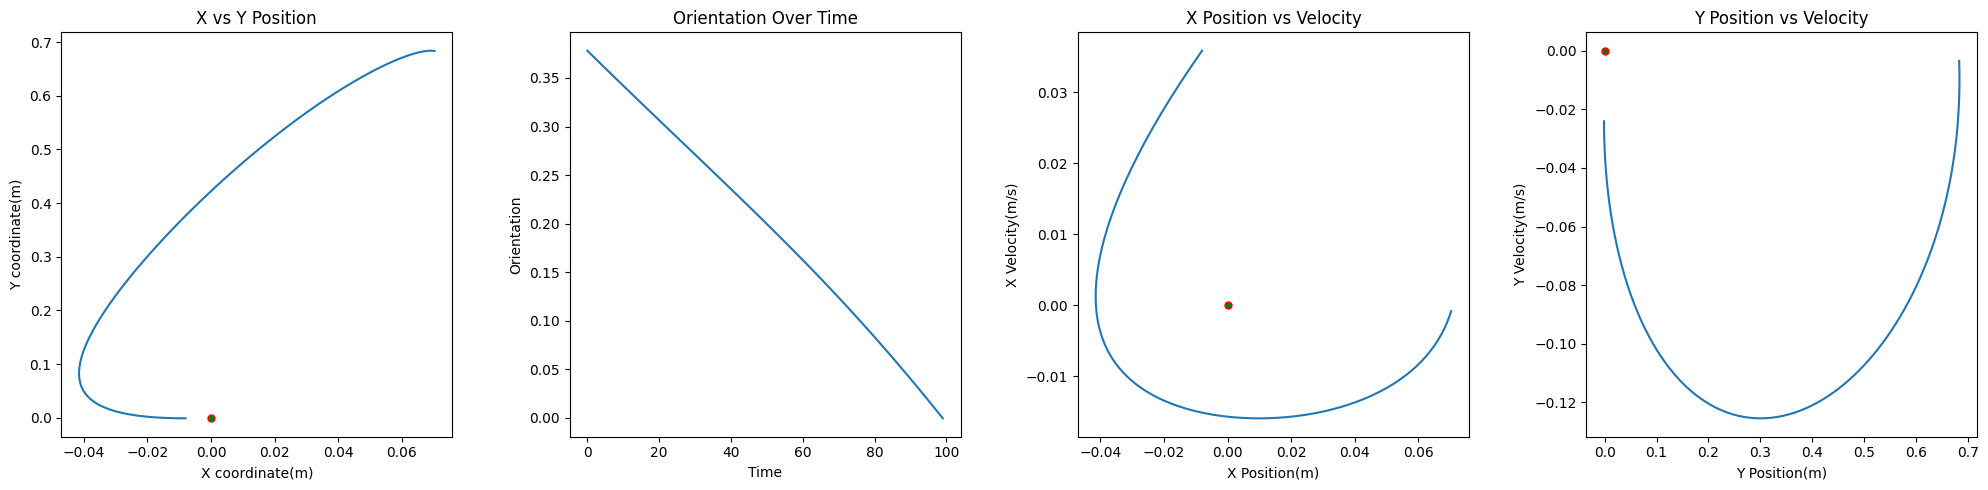



[25] loss: 0.000


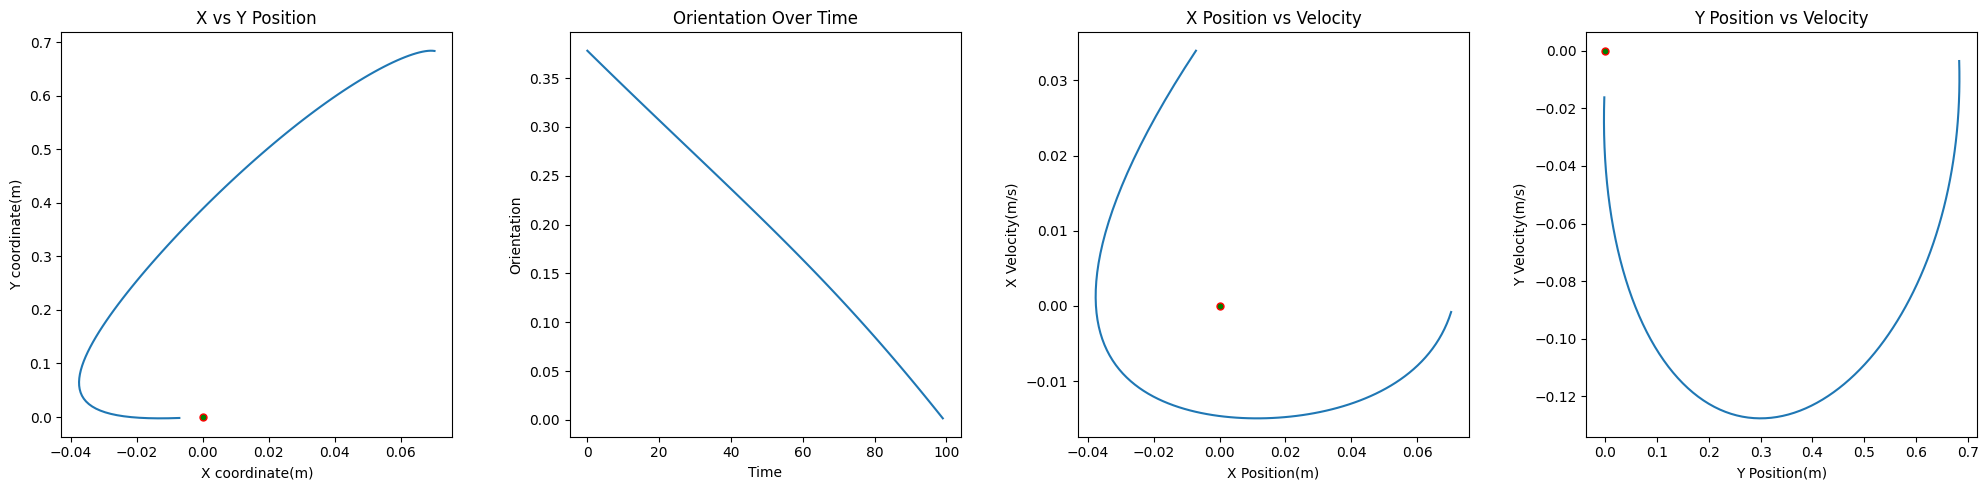



[26] loss: 0.000


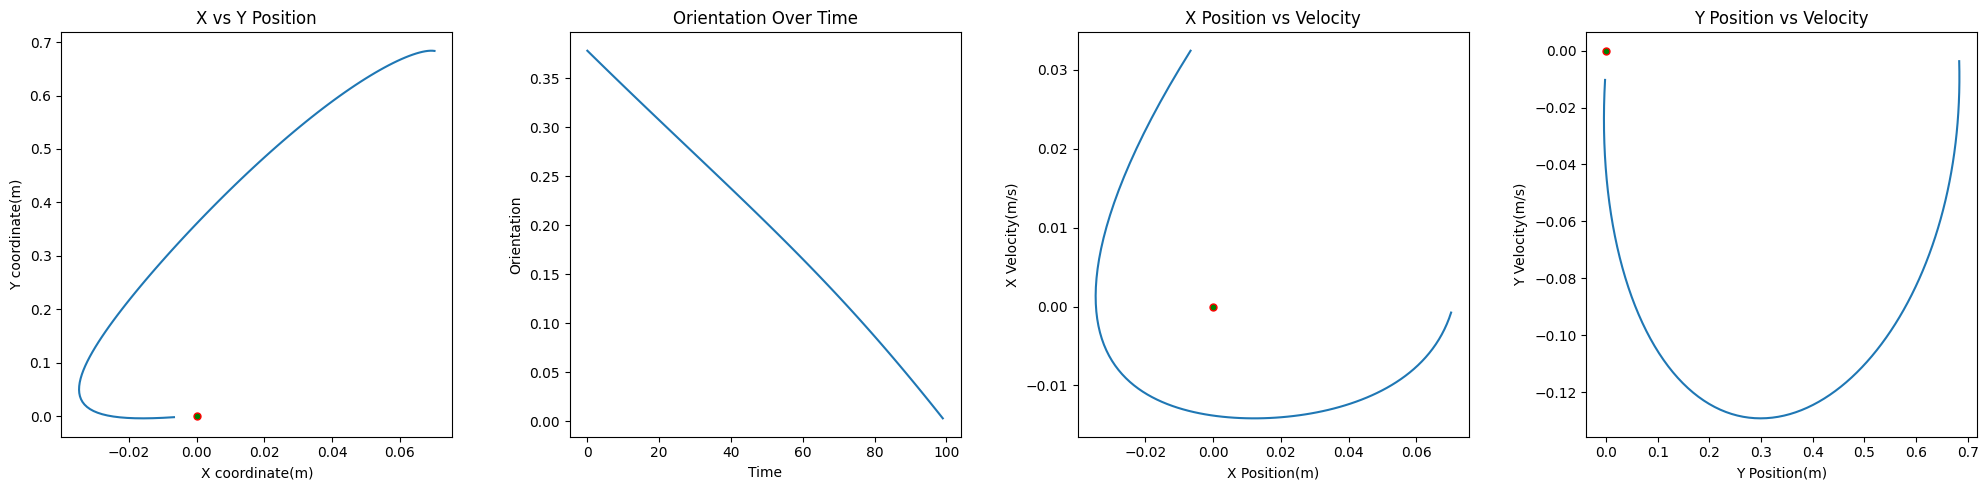



[27] loss: 0.000


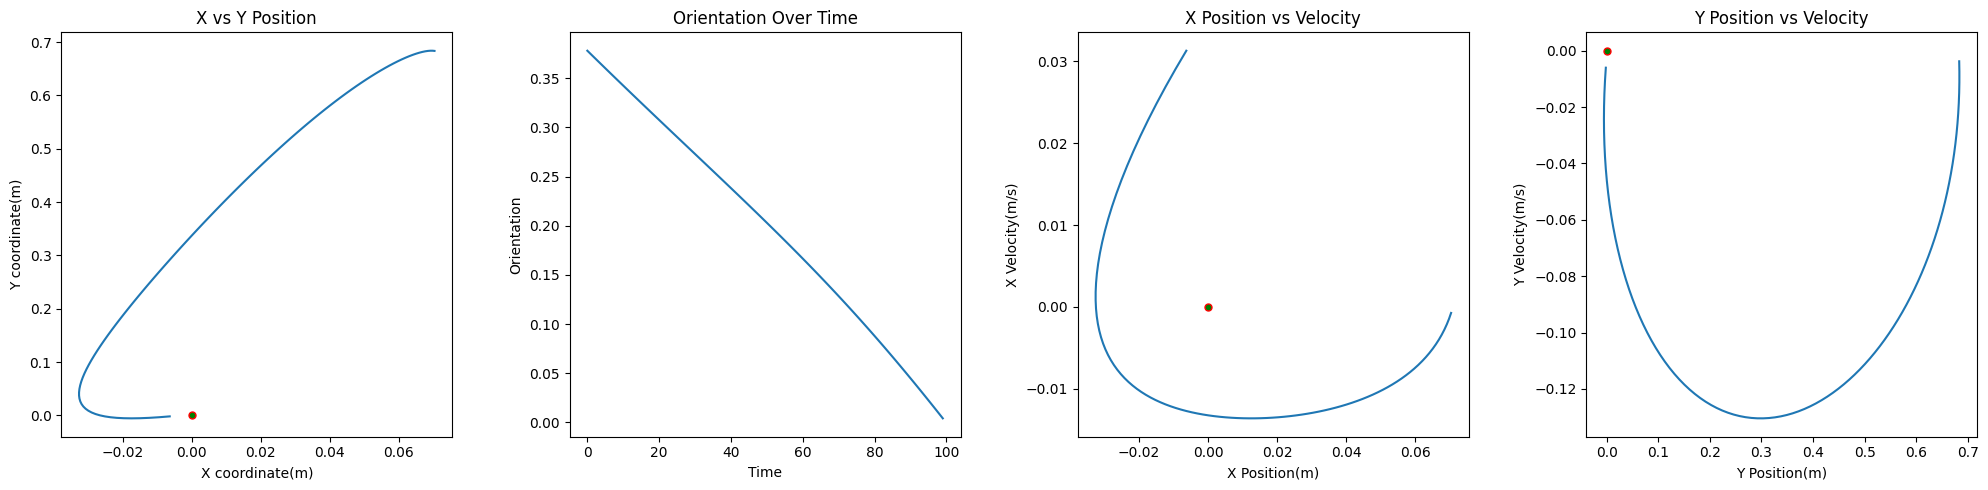



[28] loss: 0.000


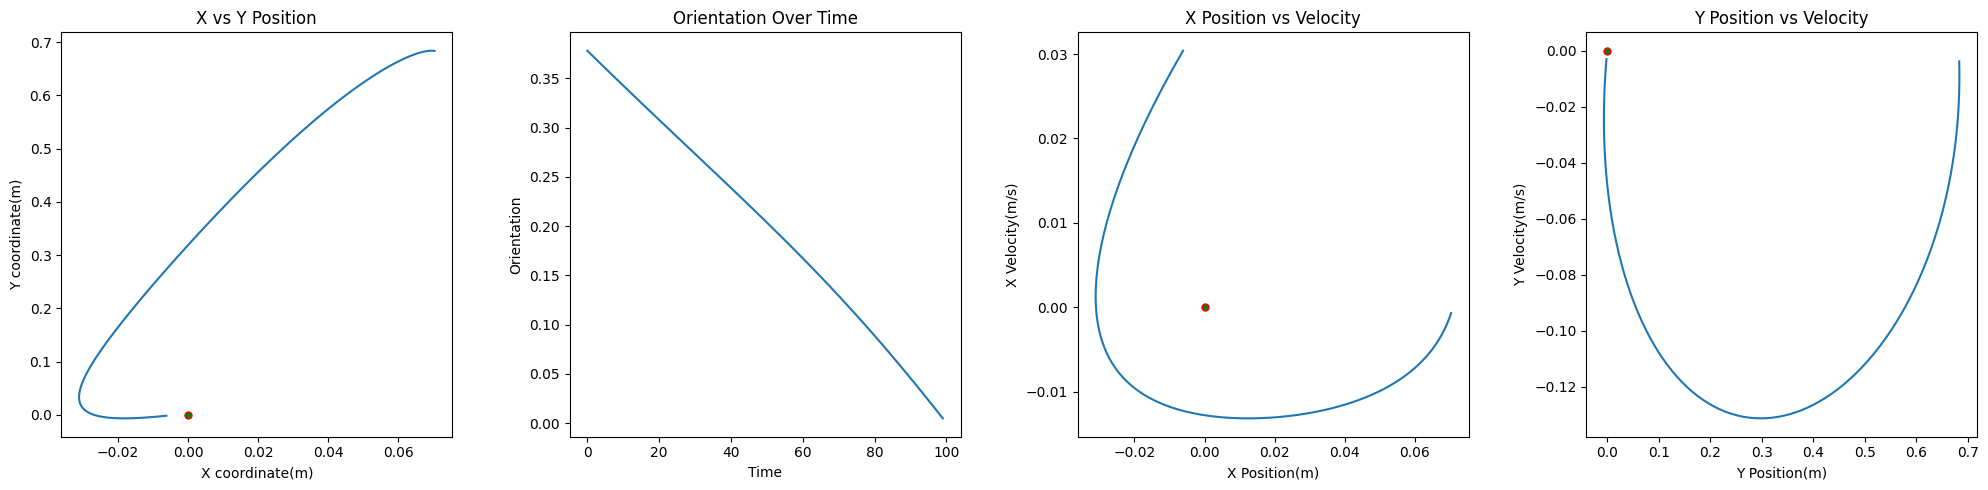



[29] loss: 0.000


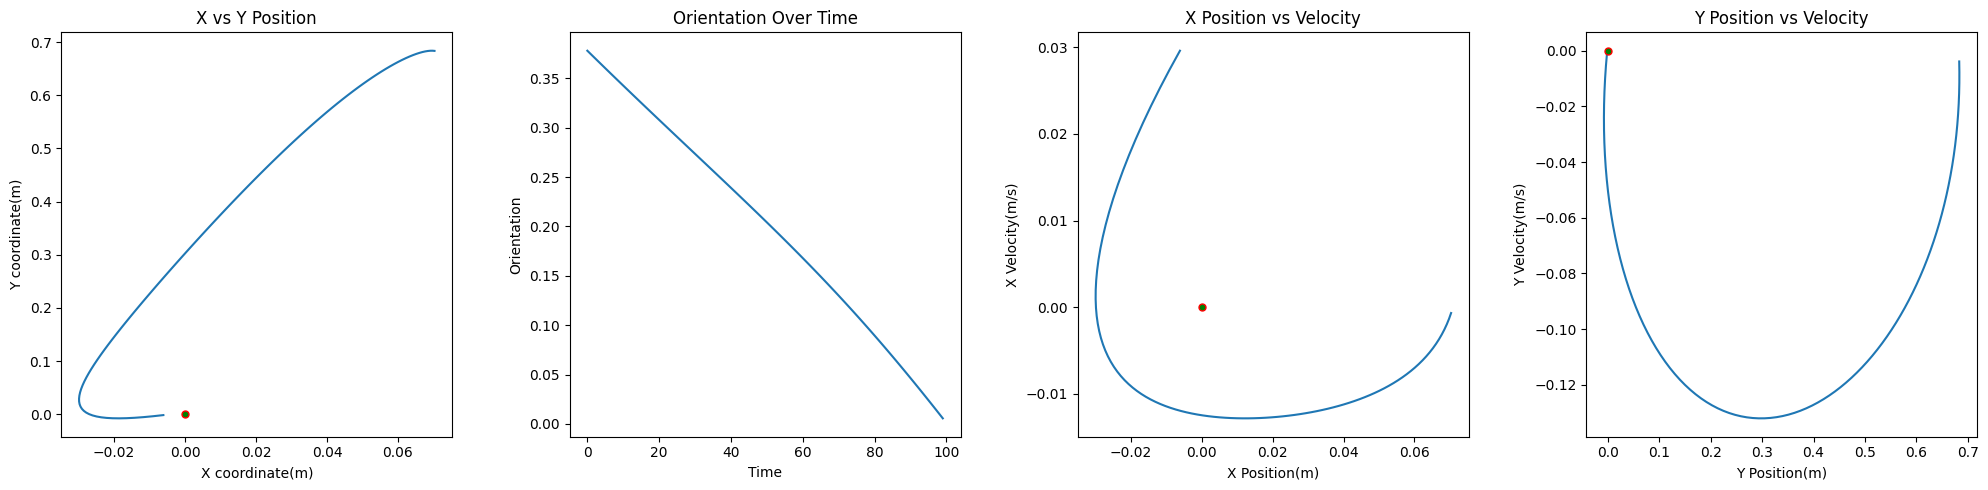



[30] loss: 0.000


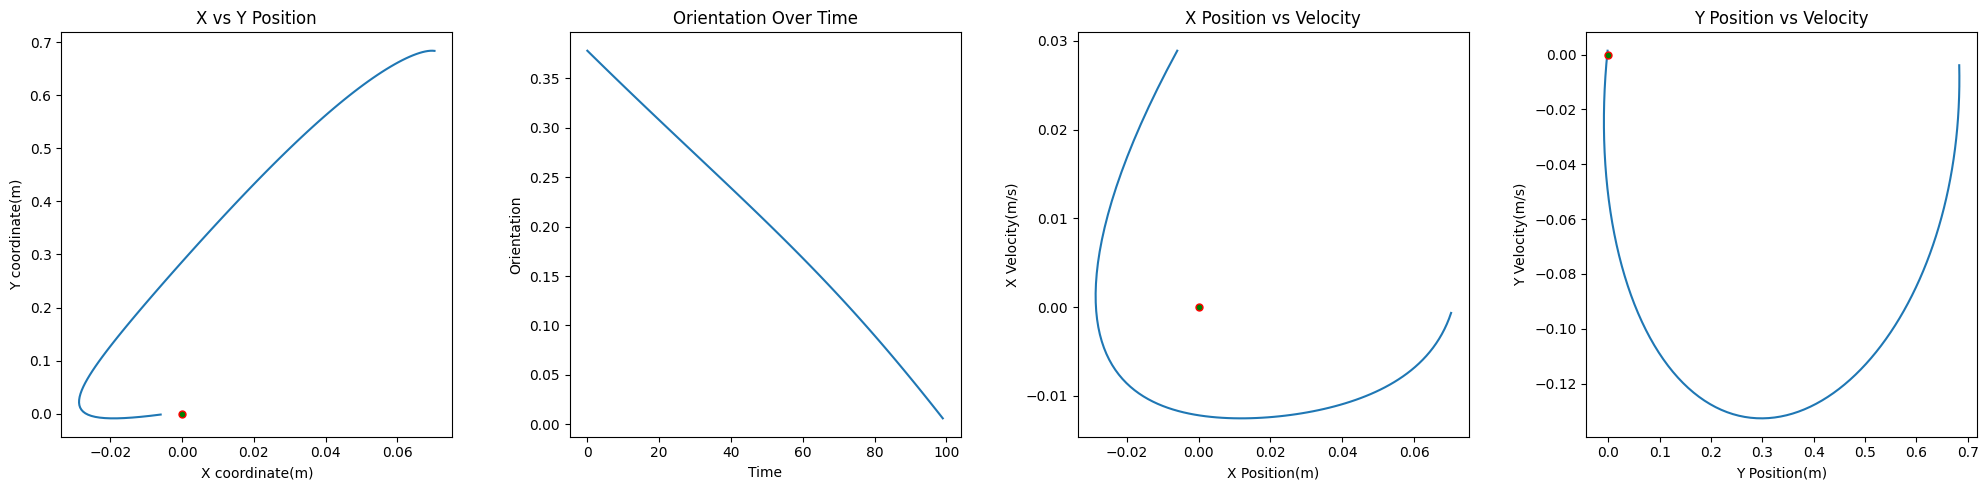



[31] loss: 0.000


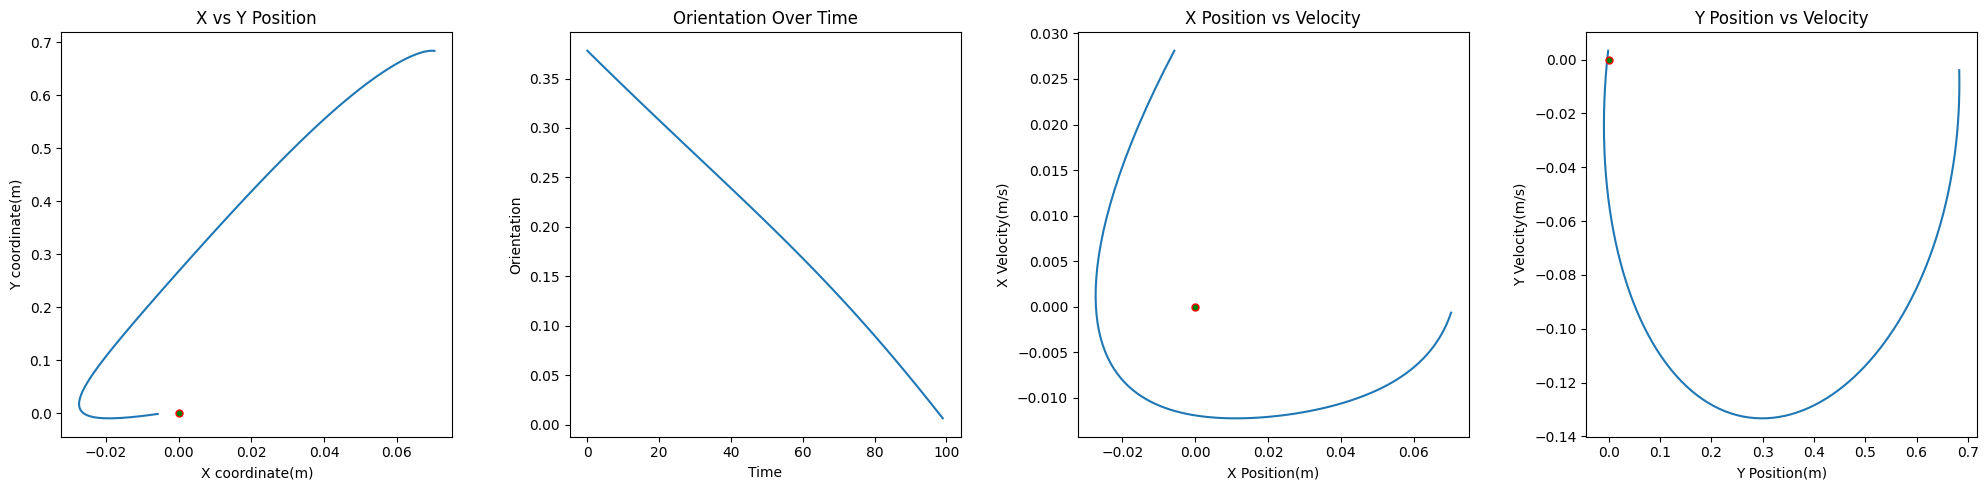



[32] loss: 0.000


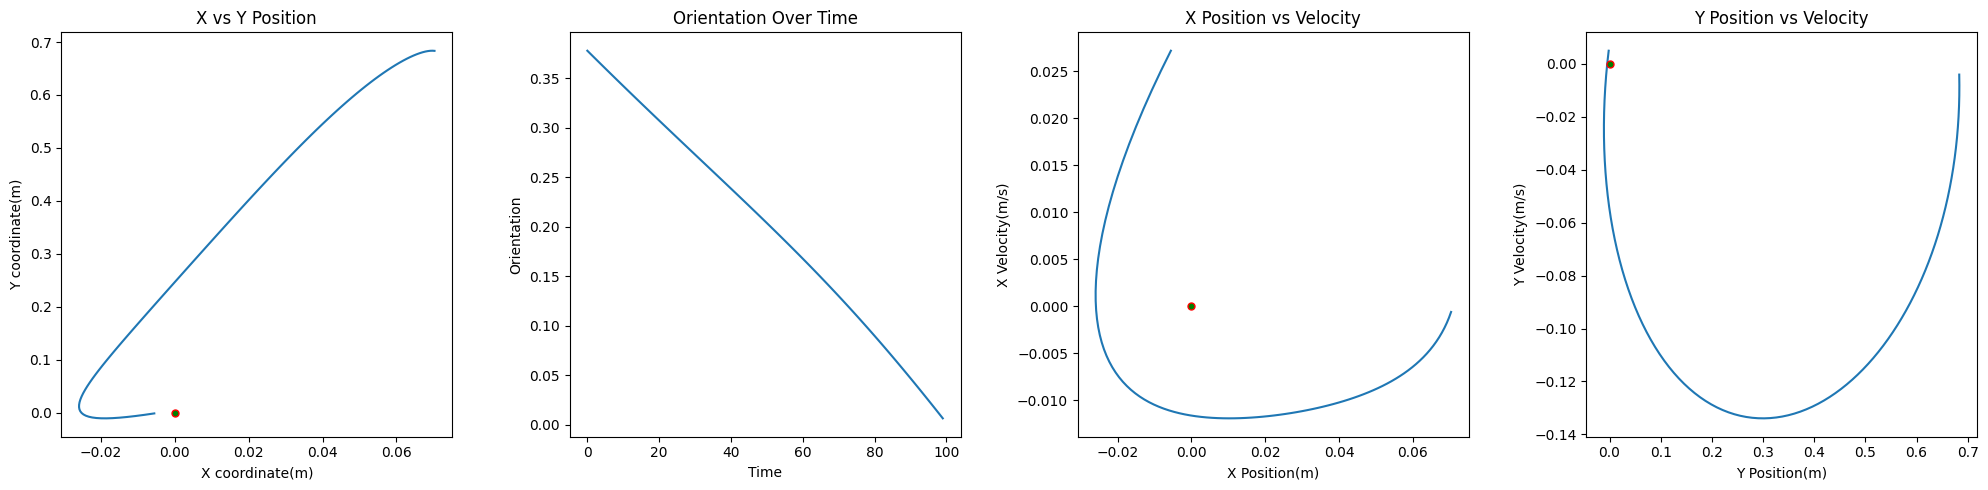



[33] loss: 0.000


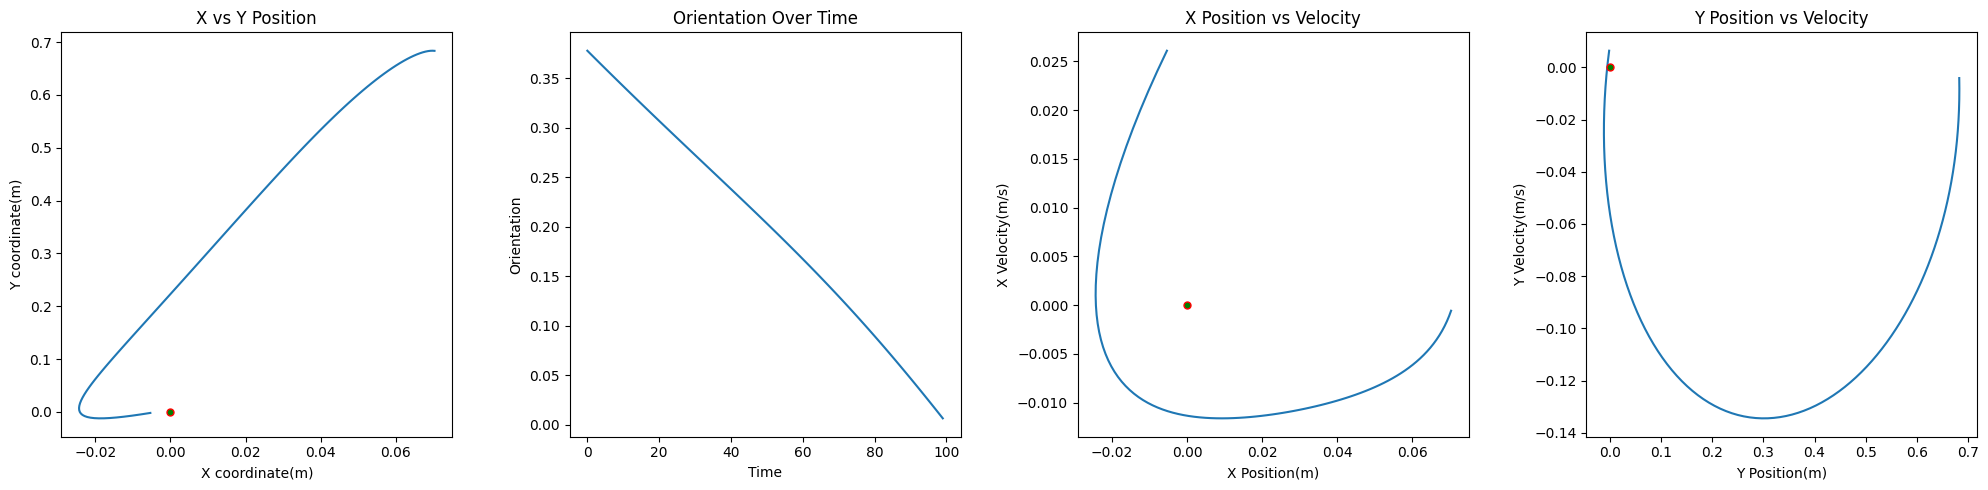



[34] loss: 0.000


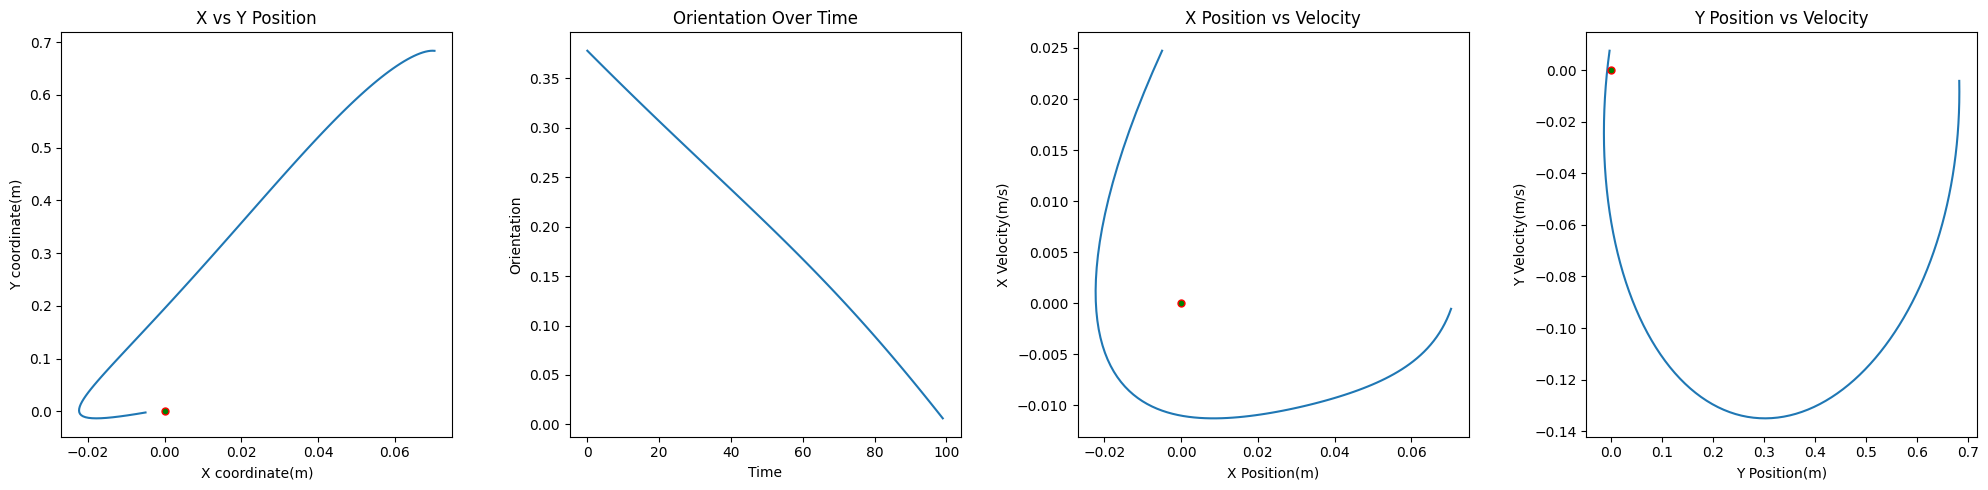



[35] loss: 0.000


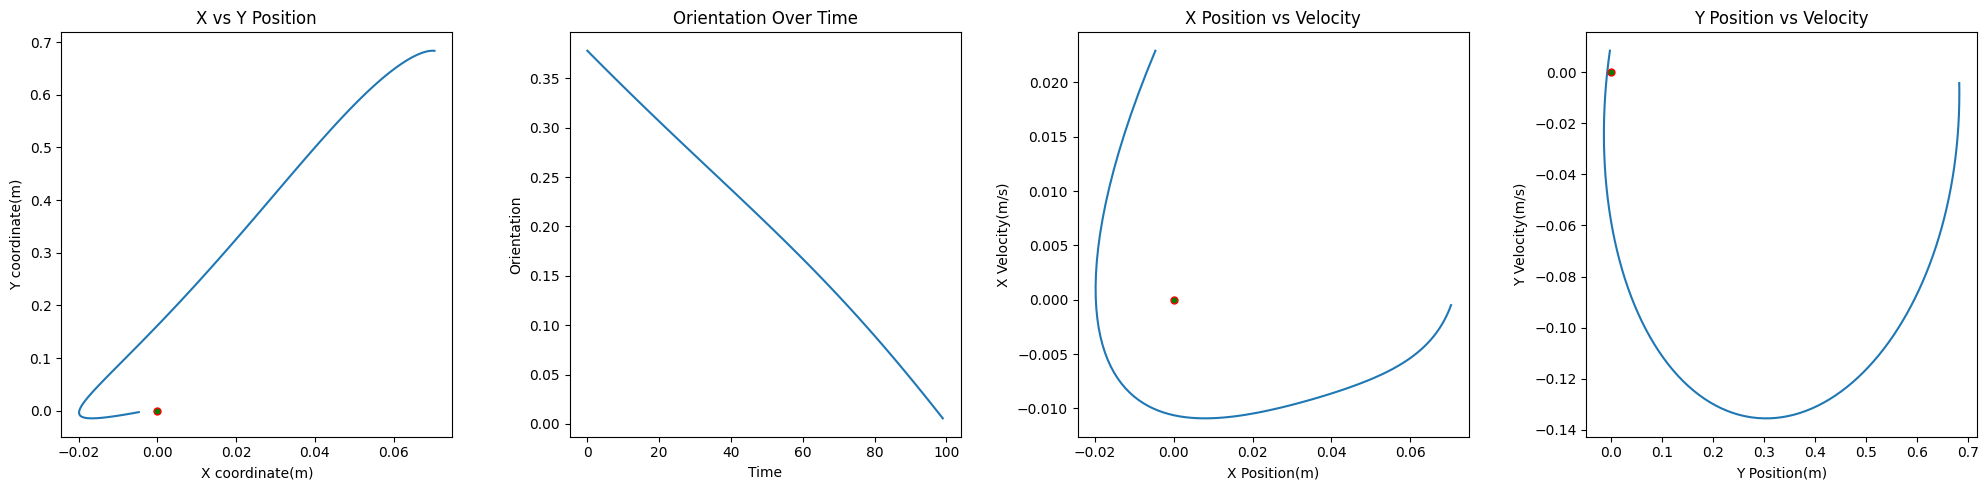



[36] loss: 0.000


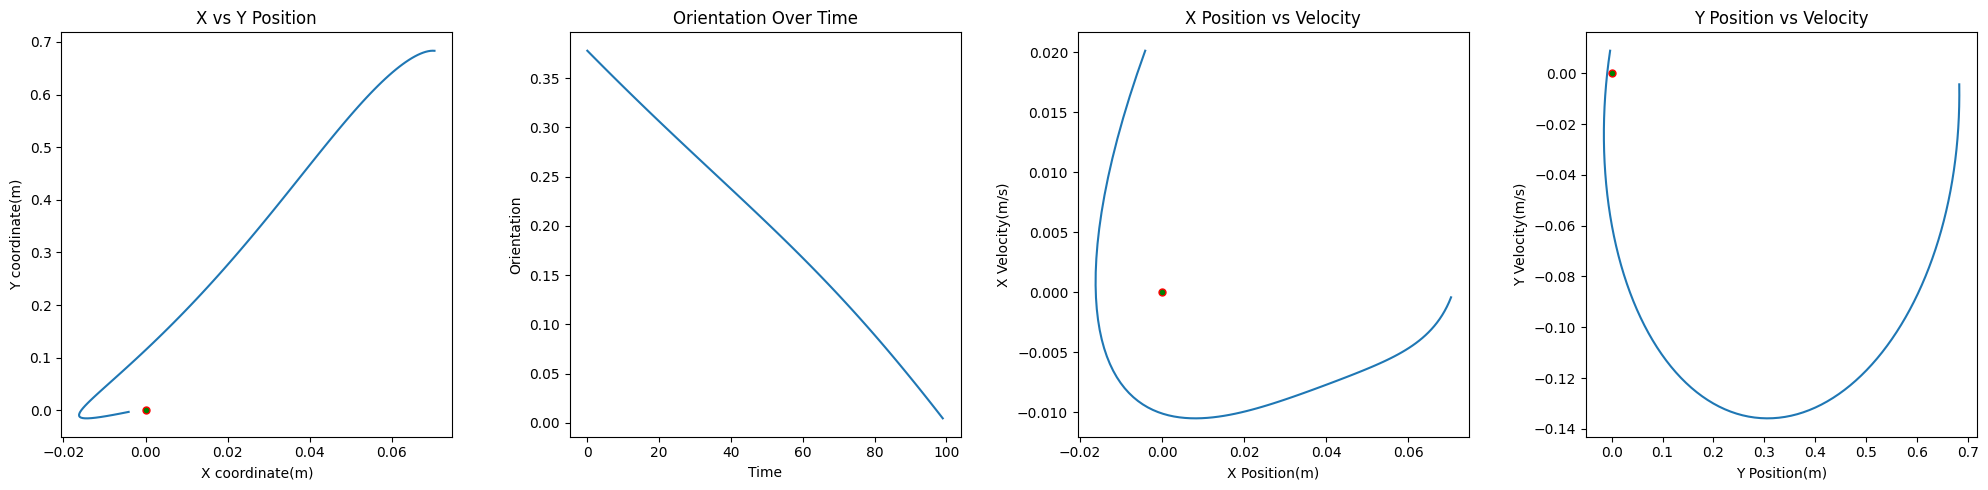



[37] loss: 0.000


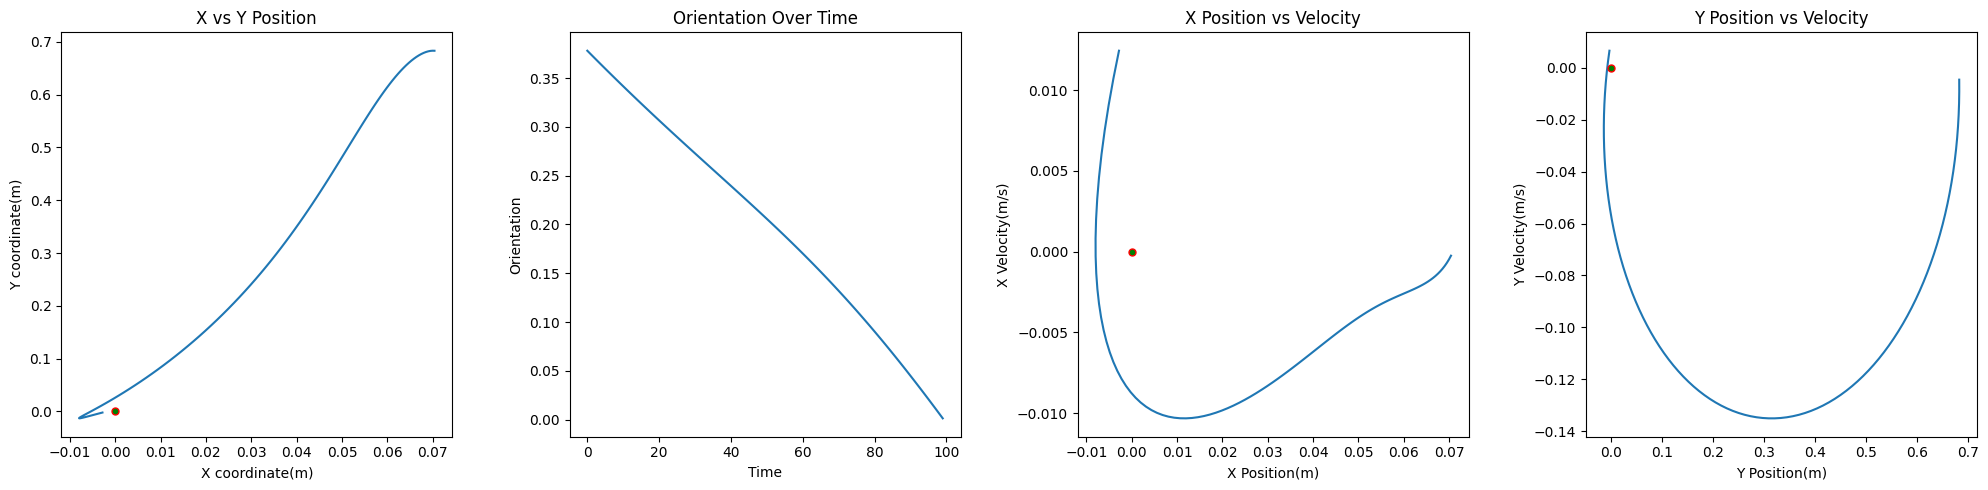



[38] loss: 0.000


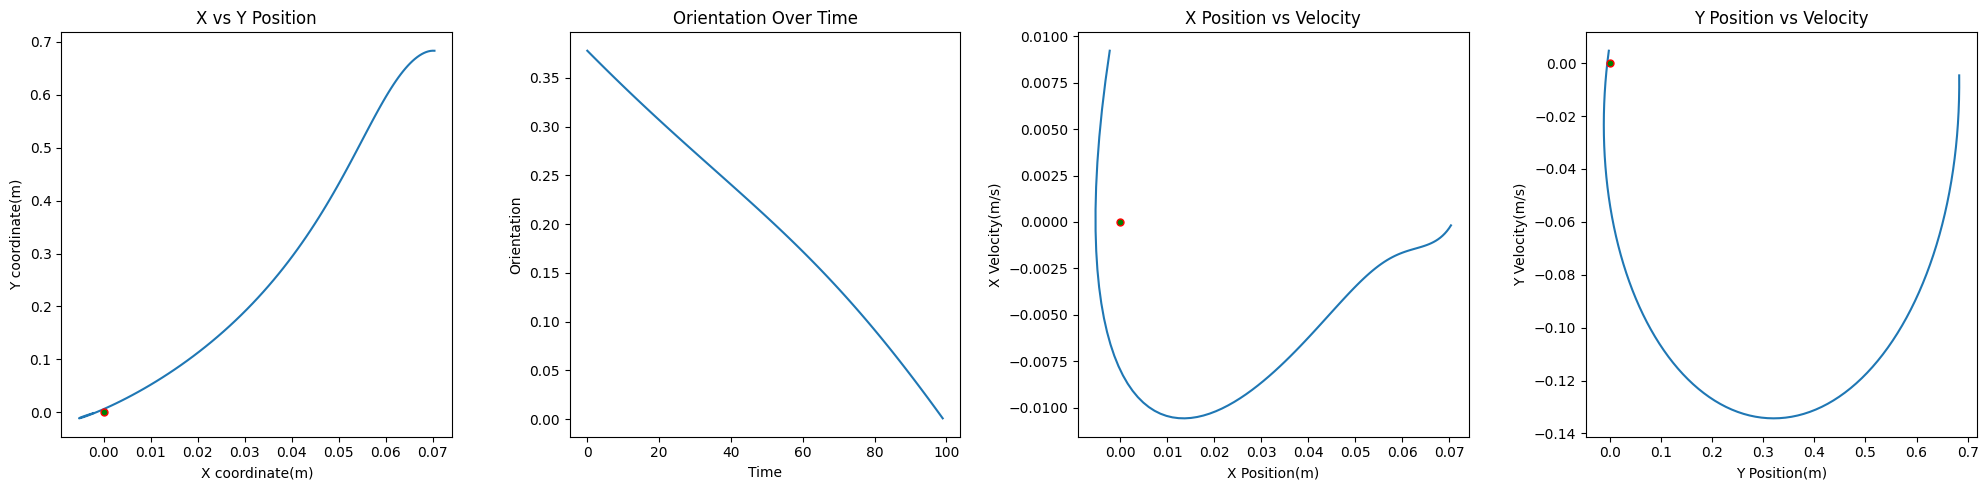



[39] loss: 0.000


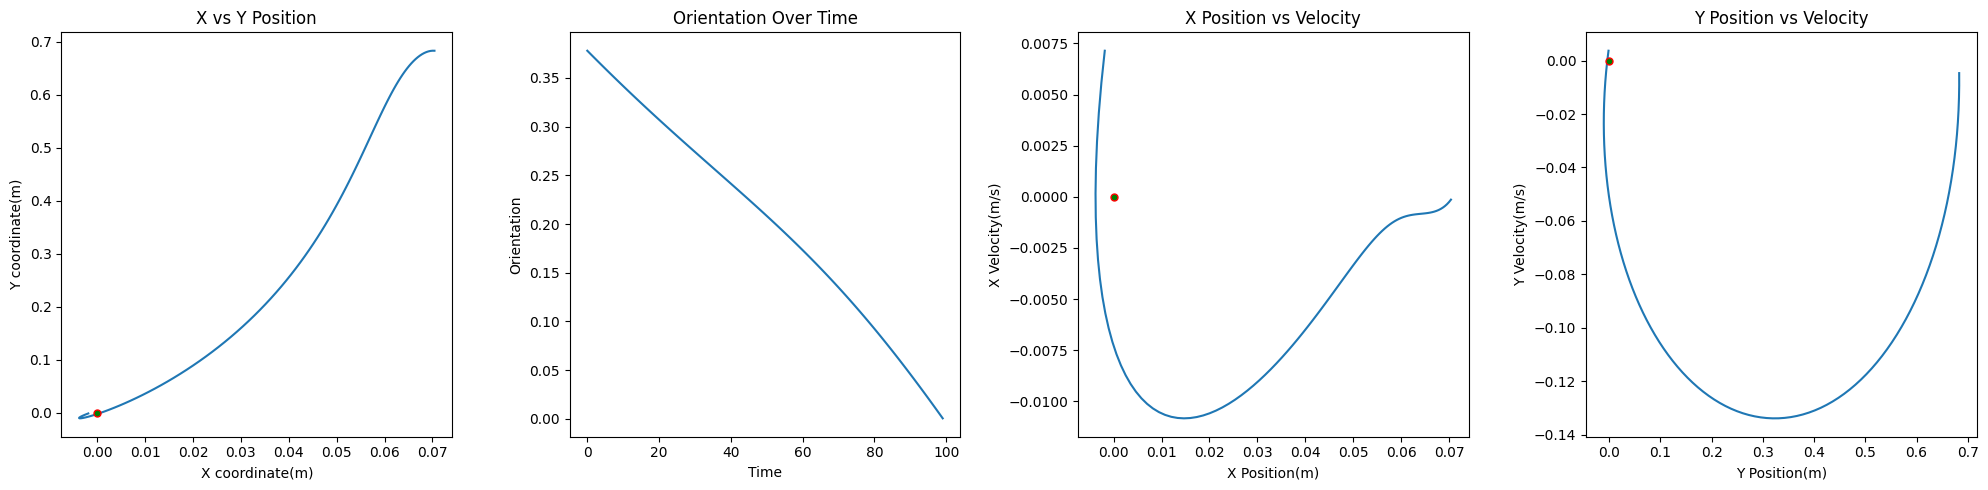



[40] loss: 0.000


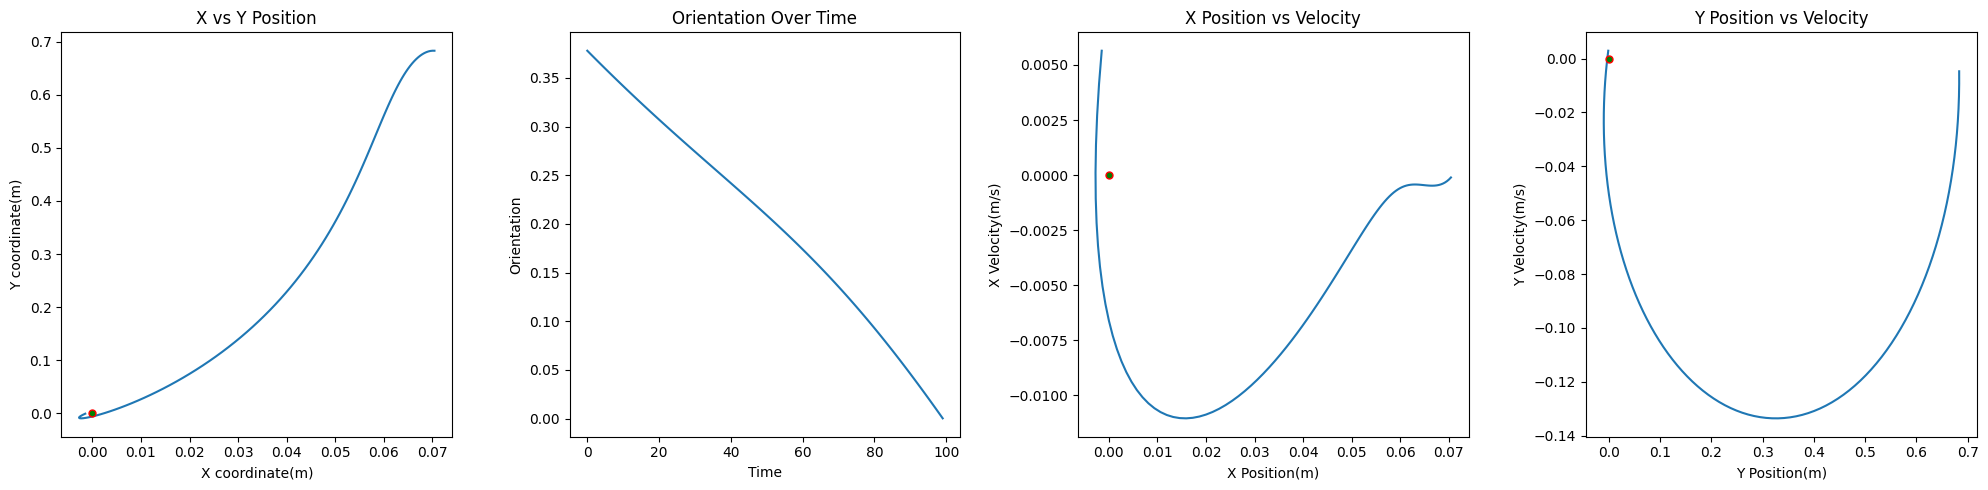



[41] loss: 0.000


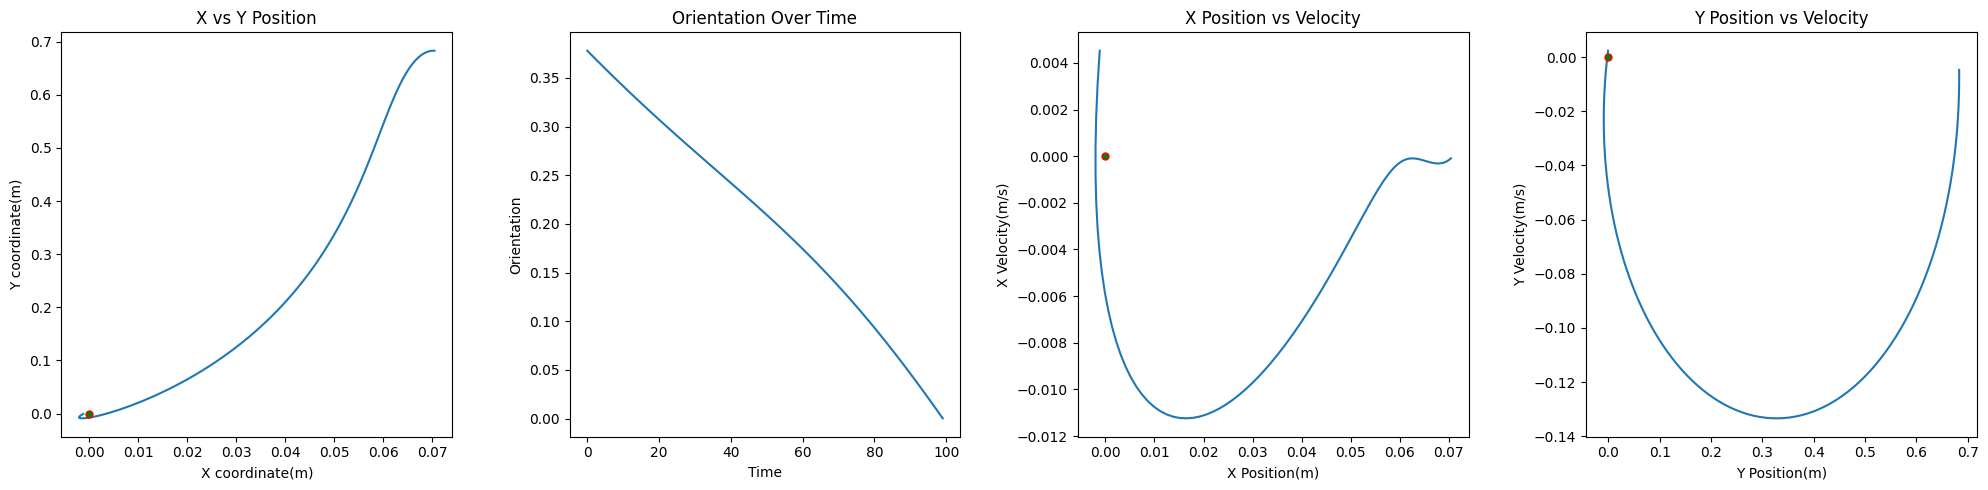



[42] loss: 0.000


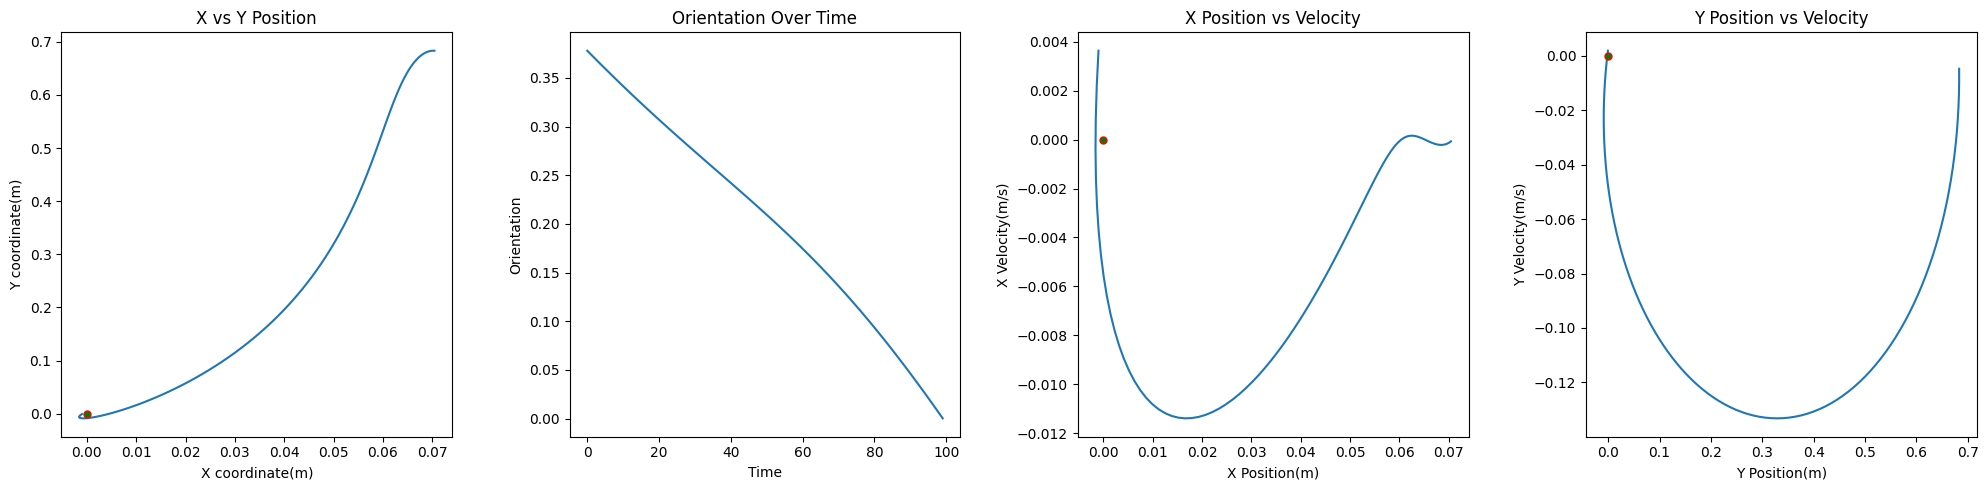



[43] loss: 0.000


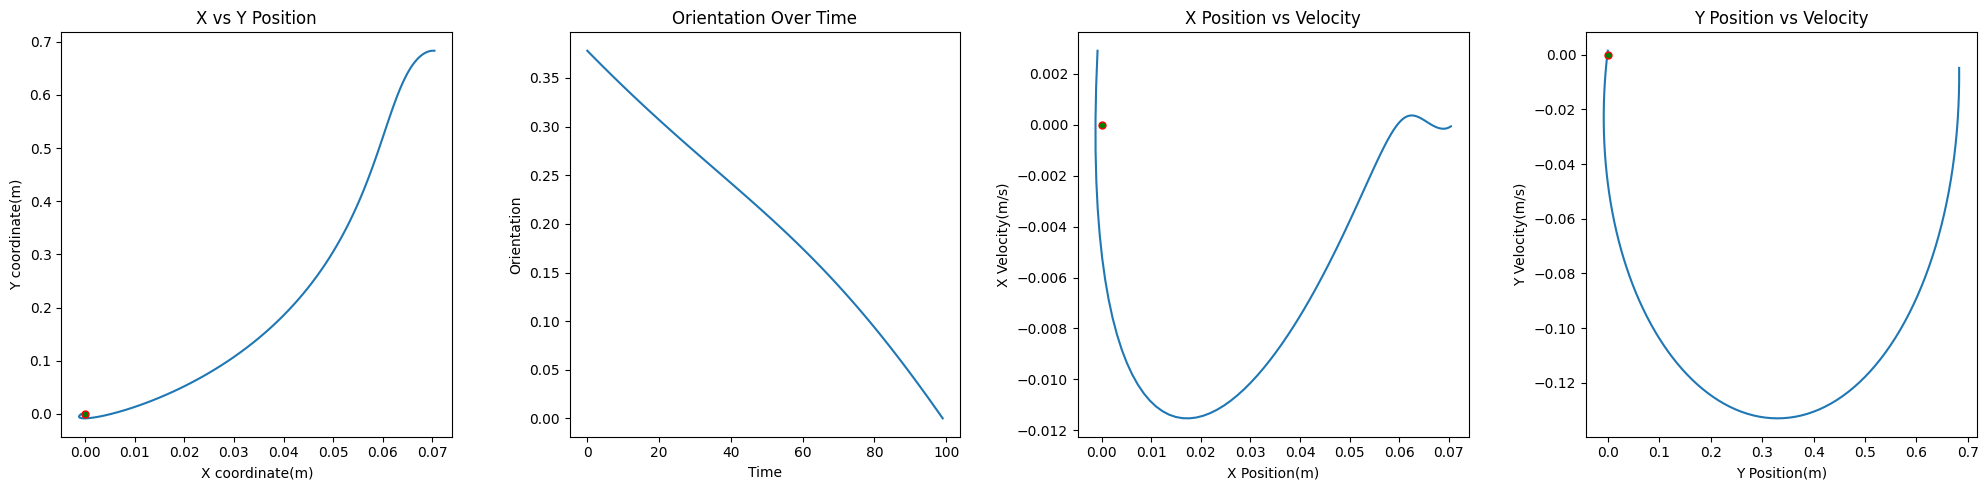



[44] loss: 0.000


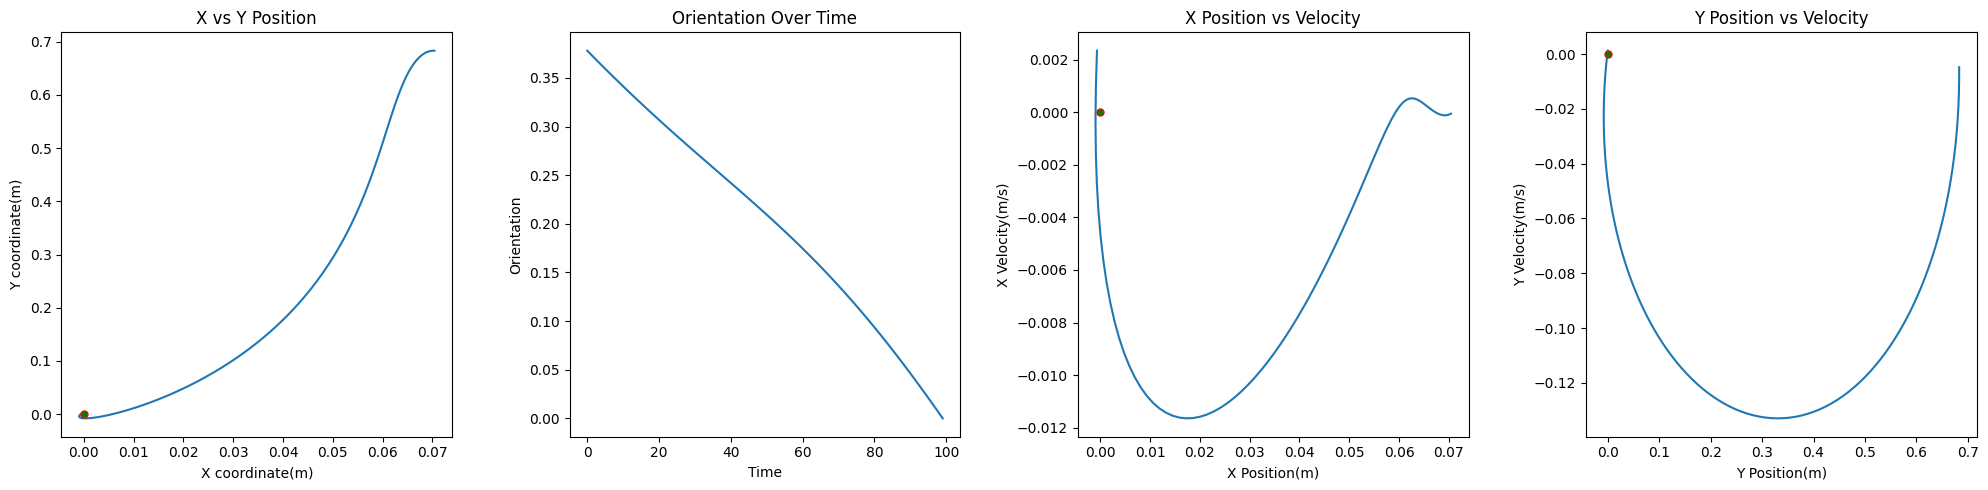



[45] loss: 0.000


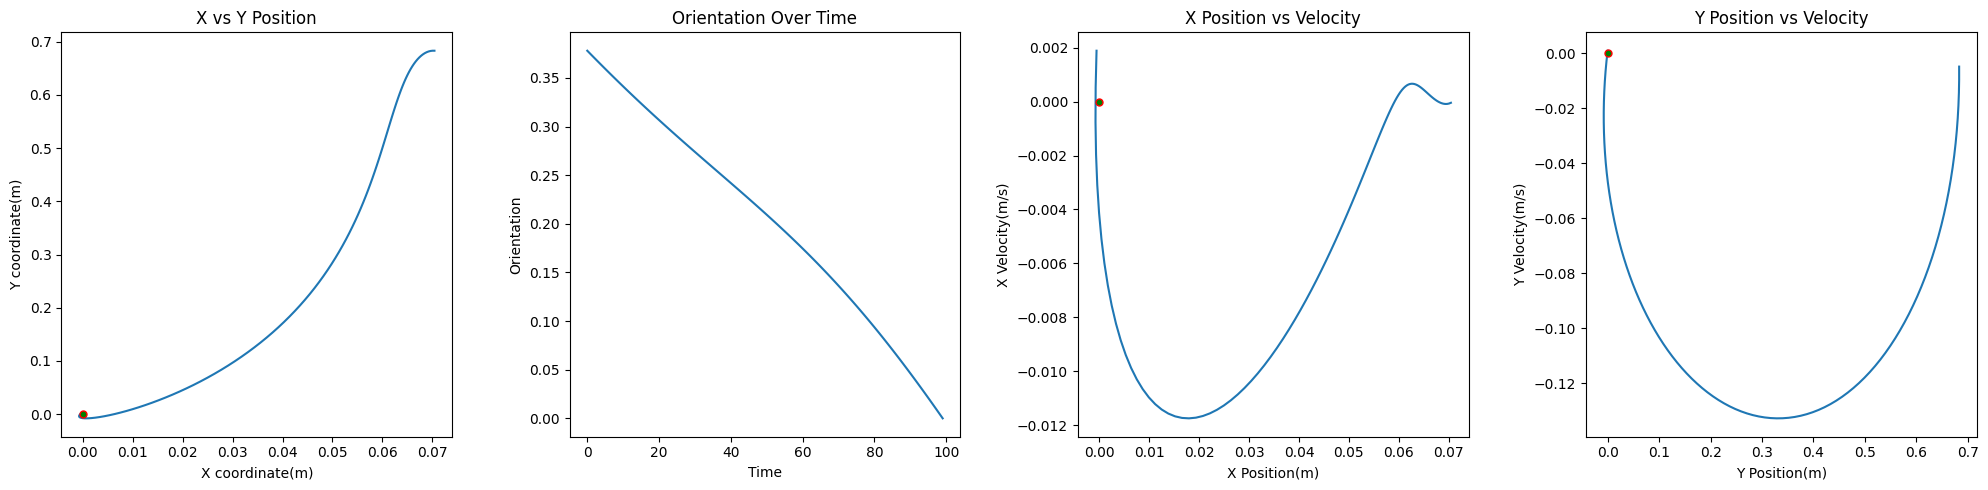



[46] loss: 0.000


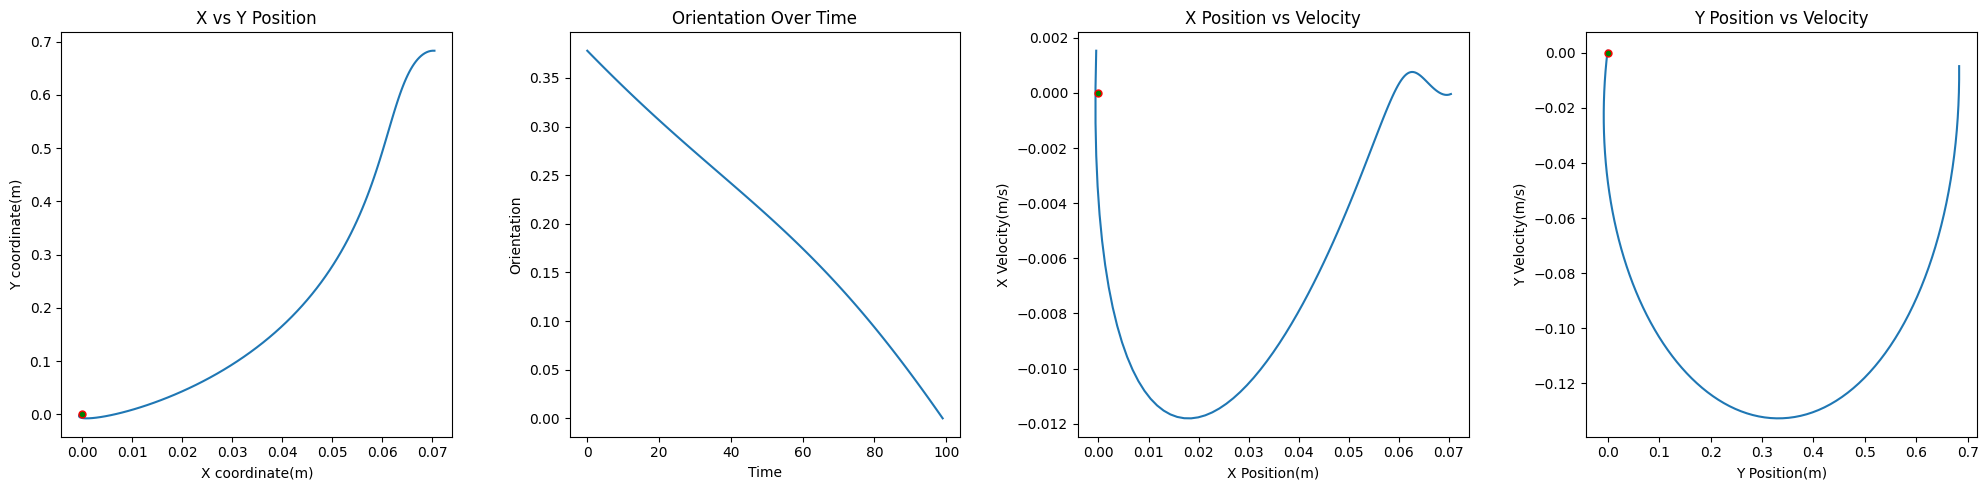



[47] loss: 0.000


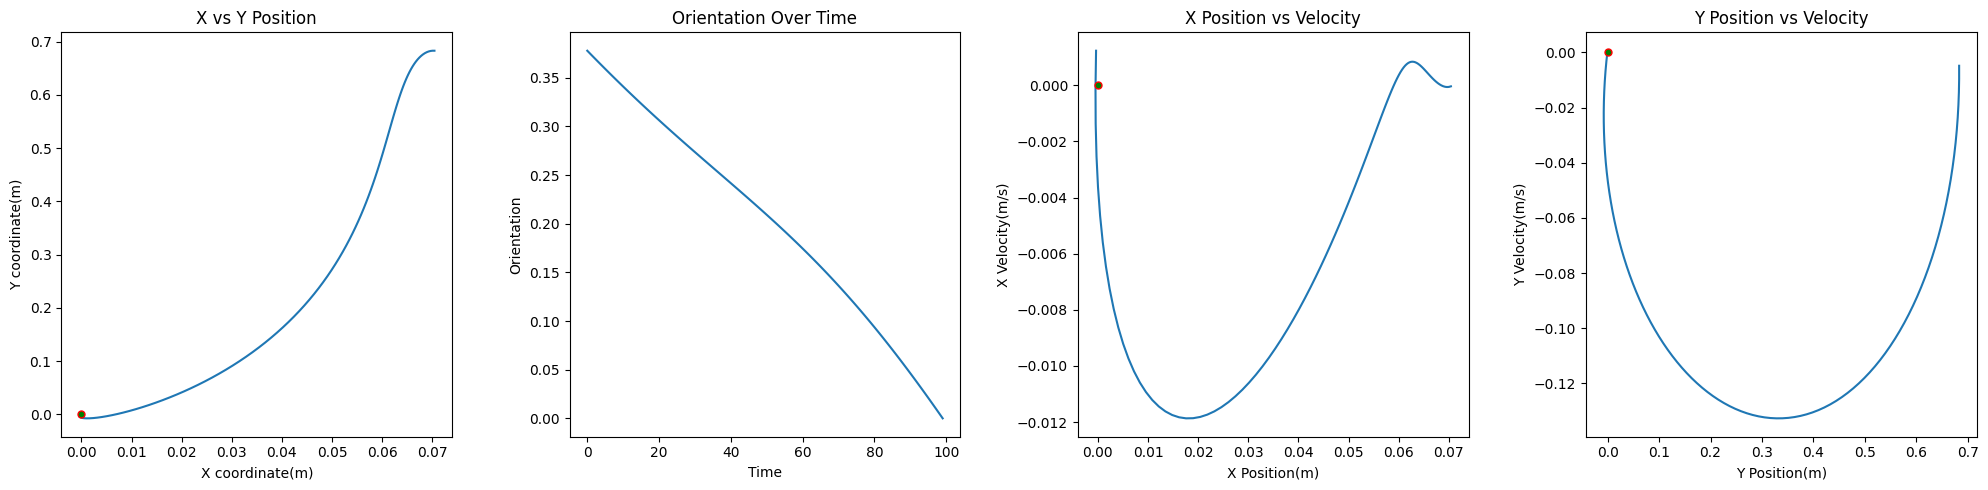



[48] loss: 0.000


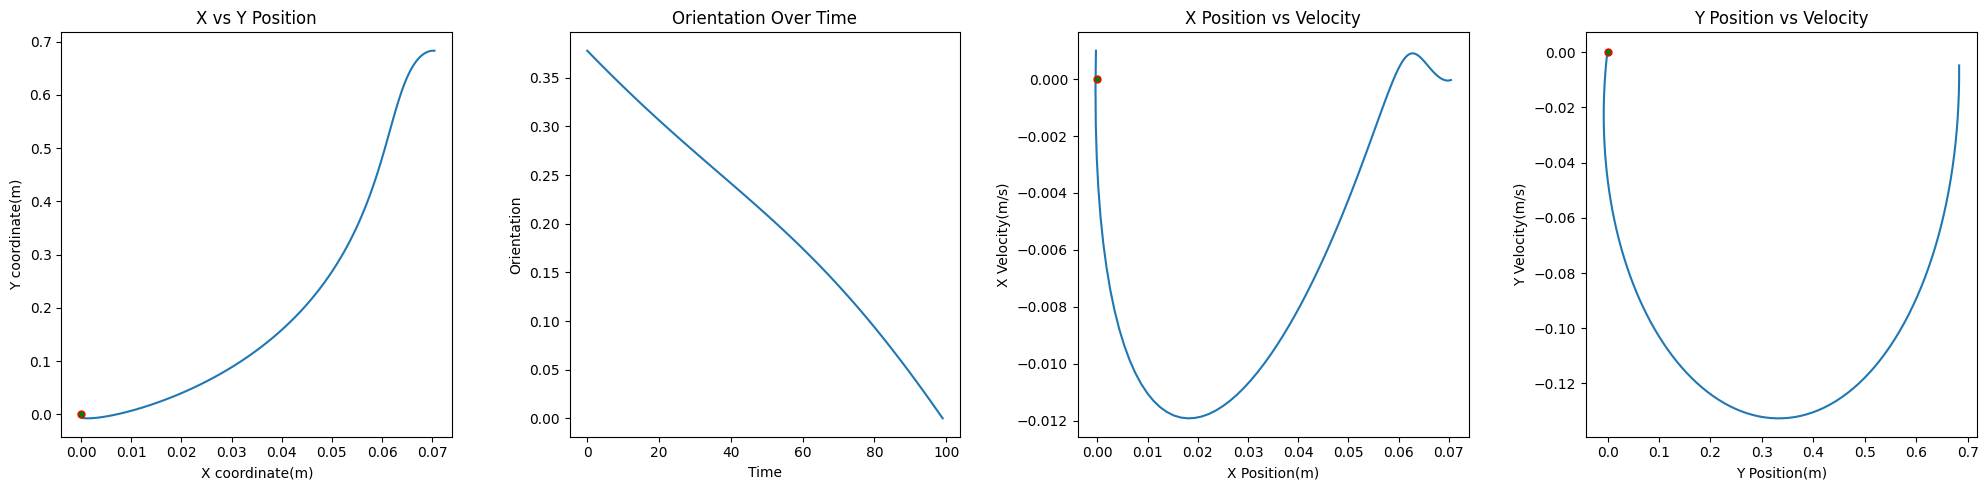



[49] loss: 0.000


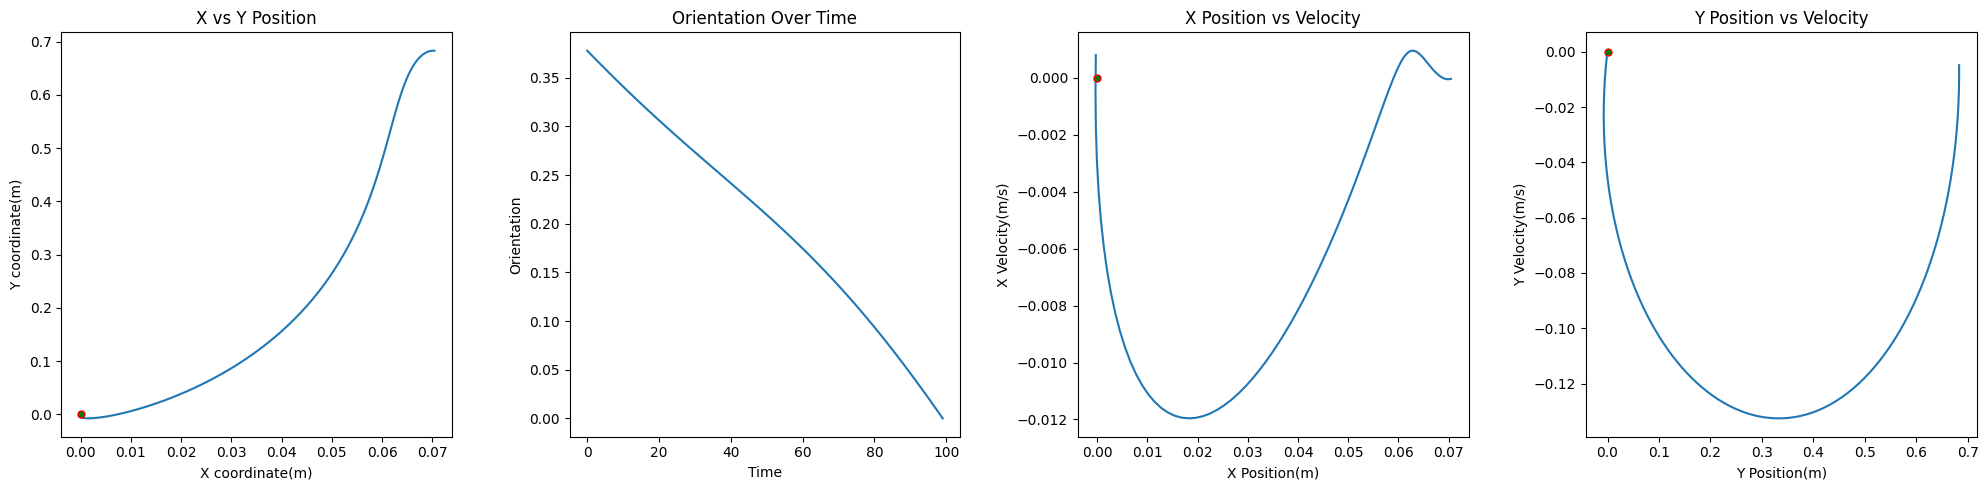



[50] loss: 0.000


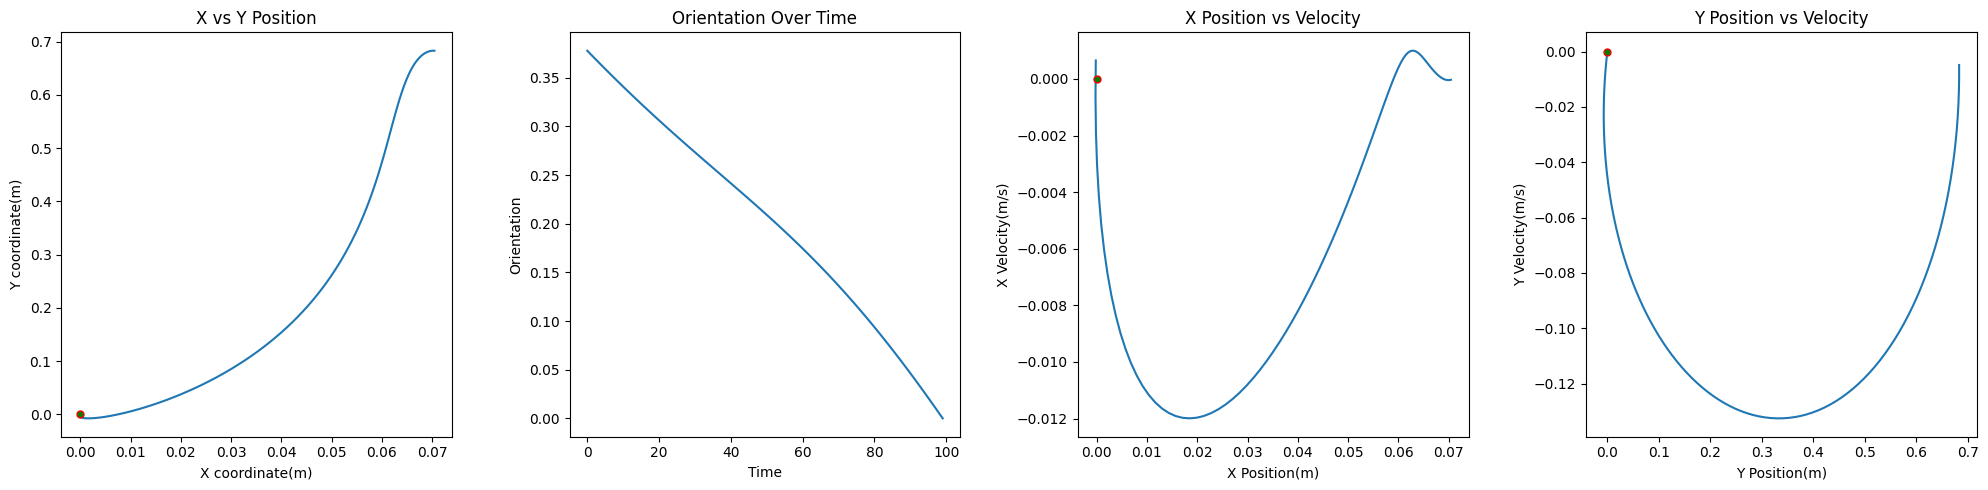

In [7]:
# Executing the code using all the elements defined above

N = 1  # number of samples
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent space dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solving the optimization problem



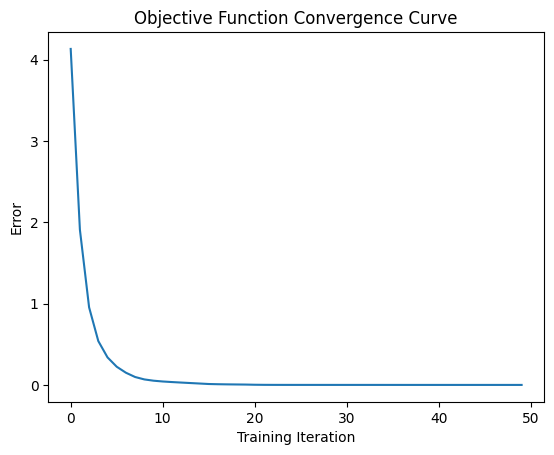

In [8]:
# Plotting Objective Function Convergence Curve
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
loss_array = [loss_item.detach().numpy() for loss_item in o.loss_list]
plt.plot(list(range(50)), loss_array)

plt.show()

In [9]:
!pip install jupyterthemes
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')


from jupyterthemes import jtplot
jtplot.style(theme='default', context='notebook', ticks=True, grid=False)

from ipywidgets import IntProgress
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00



## Animation

One sample of the trajectory of the rocket is animated.

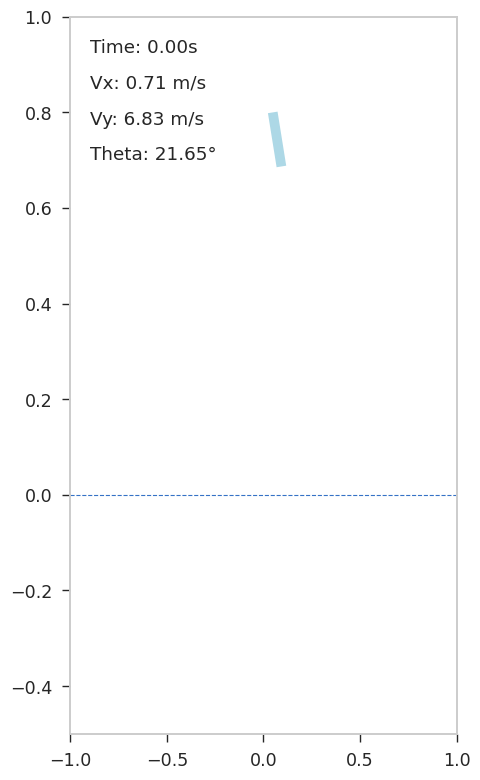

In [10]:
# Code block for creating the animation of rocket landing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import IntProgress, widgets, Dropdown
from IPython.display import display

# Load rocket states
x_t = np.load('rocket_states.npy')

# Initialize progress bar, sliders, and dropdown for animation mode
steps = 100 + 1
final_time_step = round(1 / steps, 2)
f = IntProgress(min=0, max=steps)
speed_slider = widgets.IntSlider(value=6500, min=1000, max=10000, step=500, description='Speed:')
animation_mode_dropdown = Dropdown(options=['Once', 'Loop', 'Reflect'], value='Loop', description='Mode:')
display(widgets.VBox([f, speed_slider, animation_mode_dropdown]))

# Set up the figure
fig, ax1 = plt.subplots(figsize=(5, 8))
ax1.axhline(y=0, color='b', linestyle='--', lw=0.8)

# Initialize plot elements
ln6, = ax1.plot([], [], '--', linewidth=2, color='orange')  # trajectory line
ln1, = ax1.plot([], [], linewidth=7, color='lightblue')  # rocket body
time_text = ax1.text(0.05, 0.95, '', transform=ax1.transAxes)  # time stamp
vx_text = ax1.text(0.05, 0.90, '', transform=ax1.transAxes)  # vx info
vy_text = ax1.text(0.05, 0.85, '', transform=ax1.transAxes)  # vy info
theta_text = ax1.text(0.05, 0.80, '', transform=ax1.transAxes)  # theta info

# Set plot limits and layout
ax1.set_xlim(-1, 1)
ax1.set_ylim(-0.5, 1)
plt.tight_layout()

# Update function for animation
def update(i):
    if animation_mode_dropdown.value == 'Reflect' and i >= steps // 2:
        i = steps - 1 - i

    rocket_theta = x_t[2, i]
    rocket_x = x_t[0, i]
    rocket_y = x_t[1, i]

    # Update rocket position
    rocket_x_points = [rocket_x + 0.05 * np.sin(rocket_theta), rocket_x - 0.05 * np.sin(rocket_theta)]
    rocket_y_points = [rocket_y + 0.06 - 0.05 * np.cos(rocket_theta), rocket_y + 0.06 + 0.05 * np.cos(rocket_theta)]
    ln1.set_data(rocket_x_points, rocket_y_points)

    # Update trajectory
    ln6.set_data(x_t[0, :i], x_t[1, :i])

    # Update text elements
    time_text.set_text(f'Time: {i * final_time_step:.2f}s')
    vx_text.set_text(f'Vx: {(x_t[0, i] - x_t[0, i-1])/0.1:.2f} m/s')
    vy_text.set_text(f'Vy: {(x_t[1, i] - x_t[1, i-1])/0.1:.2f} m/s')
    theta_text.set_text(f'Theta: {np.degrees(rocket_theta):.2f}°')  # Convert radians to degrees

    # Update progress bar
    f.value += 1

# Create the animation
def create_animation(speed):
    if animation_mode_dropdown.value == 'Once':
        frames = np.arange(0, steps - 1, 1)
    elif animation_mode_dropdown.value == 'Loop':
        frames = np.arange(0, steps - 1, 1)
    else:  # Reflect
        frames = np.arange(0, steps - 1, 1) * 2

    return FuncAnimation(fig, update, frames=frames, interval=final_time_step * speed, repeat=animation_mode_dropdown.value != 'Once')

# Link slider to animation speed and dropdown to animation mode
def on_change(change):
    global anim
    anim.event_source.stop()
    anim = create_animation(speed_slider.value)

speed_slider.observe(on_change, names='value')
animation_mode_dropdown.observe(on_change, names='value')

# Initialize animation
anim = create_animation(speed_slider.value)

# To display the animation in a Jupyter notebook, use the following:
from IPython.display import HTML
HTML(anim.to_html5_video())


## Discussion

The controller successfully guides the rocket to the target coordinates (0,0) in both x and y axes, achieving a stationary state in most scenarios. Enhancing the neural network by increasing its depth or width doesn't yield improvements in controlling the trajectory.